# Experiment 6: Static Pose MLP (Front vs Side - Multi-Run)

Robust comparison of front-view vs side-view pose-based models using **30-run aggregated statistics** with config-based training.

**Key Features:**
- Subject-wise stratified train/val/test splits (no subject leakage)
- Separate config files for front and side views
- 30 runs per view with different random seeds
- Comprehensive statistical analysis and visualization
- Hyperparameters saved with results for reproducibility

In [1]:
from pathlib import Path
import json
import sys
import numpy as np

PROJECT_ROOT = Path('..').resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# Force reload modules to pick up latest changes
import importlib
import src.data.data_loader
import src.data.dataset_builder
import src.scripts.experiment_6
importlib.reload(src.data.data_loader)
importlib.reload(src.data.dataset_builder)
importlib.reload(src.scripts.experiment_6)

from src.data import load_pose_data
from src.scripts.experiment_6 import train_experiment_6_multi_run

In [2]:
importlib.reload(src.utils.visualization)

from src.utils.visualization import (
    plot_confusion_matrix_from_metrics,
    plot_per_class_f1_scores,
    sort_labels_by_numeric_prefix,
    display_multi_run_summary,
    plot_multi_run_distributions,
    plot_best_worst_comparison,
    plot_aggregated_confusion_matrix,
    plot_dual_training_history,
    compare_multi_run_stats,
)
import matplotlib.pyplot as plt
import pandas as pd

# Experiment 6: Temporal Pose MLP (Front vs Side - Multi-Run)

---

## Temporal Features Baseline

This section compares **temporal pose sequences (flattened)** 

In [3]:
# Reload modules to pick up temporal training functions
importlib.reload(src.data.data_loader)
importlib.reload(src.scripts.experiment_6)

from src.data.data_loader import load_pose_temporal_data
from src.scripts.experiment_6 import train_experiment_6_temporal_multi_run

In [5]:
# Define paths to temporal pose NPZ files
front_temporal_npz = PROJECT_ROOT / 'datasets' / 'Mediapipe pose estimates' / 'pose_data_front_temporal_lite_13_angles.npz'
side_temporal_npz = PROJECT_ROOT / 'datasets' / 'Mediapipe pose estimates' / 'pose_data_side_temporal_lite_13_angles.npz'

# Load and summarize front-view temporal data
front_temporal_dataset, front_temporal_summary = load_pose_temporal_data(str(front_temporal_npz))
print("Front-view temporal features:")
print(f"  Samples: {front_temporal_summary['count']}")
print(f"  Subjects: {front_temporal_summary['unique_subjects']}")
print(f"  Classes: {front_temporal_summary['unique_classes']}")
print(f"  Temporal shape: {front_temporal_summary['temporal_shape']} (timesteps × angles)")
print(f"  Flattened to: {front_temporal_summary['temporal_shape'][0] * front_temporal_summary['temporal_shape'][1]} features per sample")


# Load and summarize side-view temporal data
side_temporal_dataset, side_temporal_summary = load_pose_temporal_data(str(side_temporal_npz))
print("\nSide-view temporal features:")
print(f"  Samples: {side_temporal_summary['count']}")
print(f"  Subjects: {side_temporal_summary['unique_subjects']}")
print(f"  Classes: {side_temporal_summary['unique_classes']}")
print(f"  Temporal shape: {side_temporal_summary['temporal_shape']} (timesteps × angles)")
print(f"  Flattened to: {side_temporal_summary['temporal_shape'][0] * side_temporal_summary['temporal_shape'][1]} features per sample")

INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)


Front-view temporal features:
  Samples: 1574
  Subjects: 49
  Classes: 15
  Temporal shape: (50, 13) (timesteps × angles)
  Flattened to: 650 features per sample

Side-view temporal features:
  Samples: 1571
  Subjects: 49
  Classes: 15
  Temporal shape: (50, 13) (timesteps × angles)
  Flattened to: 650 features per sample


---

## Multi-Run Training: Temporal Front View (30 Runs)

Execute 30 training runs with different random seeds using `config/experiment_6_temporal_front.yaml`.

**Configuration:**
- Temporal sequences flattened to 1D vectors (8 angles × 50 timesteps = 400 features)
- Results saved to `experiments/exer_recog/results/exp_06_pose_mlp_temporal/front/`
- Same MLP architecture as static (256 → 128 hidden layers)
- Early stopping with patience=30 on validation loss

In [9]:
# Train temporal front-view model with multi-run (30 runs)
print("=" * 80)
print("MULTI-RUN TRAINING: TEMPORAL FRONT VIEW (30 RUNS)")
print("=" * 80)

config_path_temporal_front = PROJECT_ROOT / 'config' / 'experiment_6_temporal_front.yaml'

multi_run_results_temporal_front, aggregated_stats_temporal_front = train_experiment_6_temporal_multi_run(
    npz_path=str(front_temporal_npz),
    config_path=str(config_path_temporal_front)
)

print("\n✅ Temporal front-view multi-run training complete!")
print(f"Mean Test Accuracy: {aggregated_stats_temporal_front['test_accuracy']['mean']:.4f} ± {aggregated_stats_temporal_front['test_accuracy']['std']:.4f}")
print(f"Mean Test Macro F1: {aggregated_stats_temporal_front['test_macro_f1']['mean']:.4f} ± {aggregated_stats_temporal_front['test_macro_f1']['std']:.4f}")

INFO - Multi-run parent folder: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006
INFO - 
INFO - Starting run 1/30 (seed=43)
INFO - ================================================================================
INFO - Global random seed set to: 43
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=897, val=288, test=389, classes=15
INFO - Datasets built with feature_dim=650


MULTI-RUN TRAINING: TEMPORAL FRONT VIEW (30 RUNS)
Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.1405 - loss: 2.8481 - val_accuracy: 0.5104 - val_loss: 1.9838 - learning_rate: 8.0000e-05
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3233 - loss: 2.0919 - val_accuracy: 0.6076 - val_loss: 1.5870 - learning_rate: 8.0000e-05
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5084 - loss: 1.6682 - val_accuracy: 0.6493 - val_loss: 1.3404 - learning_rate: 8.0000e-05
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6109 - loss: 1.3657 - val_accuracy: 0.6910 - val_loss: 1.1197 - learning_rate: 8.0000e-05
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6656 - loss: 1.0985 - val_accuracy: 0.7153 - val_loss: 0.9797 - learning_rate: 8.0000e-05
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7302 - loss: 0.9483 - val_accuracy: 0.7361 - val_loss: 0.8455 - learning_rate: 8.0000e-05
Epoch 7/150
57/57 ━

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_001/model.keras
INFO - Run 1 complete: acc=0.8638, macro_f1=0.8634
INFO - 
INFO - Starting run 2/30 (seed=44)
INFO - ================================================================================
INFO - Global random seed set to: 44
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=903, val=248, test=423, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1395 - loss: 2.8748 - val_accuracy: 0.5081 - val_loss: 1.9409 - learning_rate: 8.0000e-05
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3466 - loss: 2.0469 - val_accuracy: 0.6815 - val_loss: 1.5109 - learning_rate: 8.0000e-05
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4740 - loss: 1.6679 - val_accuracy: 0.7782 - val_loss: 1.2367 - learning_rate: 8.0000e-05
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5681 - loss: 1.3876 - val_accuracy: 0.8306 - val_loss: 1.0509 - learning_rate: 8.0000e-05
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6445 - loss: 1.1683 - val_accuracy: 0.8185 - val_loss: 0.9245 - learning_rate: 8.0000e-05
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7198 - loss: 0.9434 - val_accuracy: 0.8105 - val_loss: 0.8506 - learning_rate: 8.0000e-05
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7597

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_002/model.keras
INFO - Run 2 complete: acc=0.8203, macro_f1=0.8150
INFO - 
INFO - Starting run 3/30 (seed=45)
INFO - ================================================================================
INFO - Global random seed set to: 45
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=770, val=260, test=544, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1571 - loss: 2.7000 - val_accuracy: 0.4885 - val_loss: 1.9937 - learning_rate: 8.0000e-05
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3416 - loss: 2.0893 - val_accuracy: 0.6654 - val_loss: 1.5089 - learning_rate: 8.0000e-05
Epoch 3/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4857 - loss: 1.6962 - val_accuracy: 0.7846 - val_loss: 1.1598 - learning_rate: 8.0000e-05
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5701 - loss: 1.4513 - val_accuracy: 0.7846 - val_loss: 0.9297 - learning_rate: 8.0000e-05
Epoch 5/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6494 - loss: 1.1843 - val_accuracy: 0.8462 - val_loss: 0.7718 - learning_rate: 8.0000e-05
Epoch 6/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7195 - loss: 0.9901 - val_accuracy: 0.8731 - val_loss: 0.6667 - learning_rate: 8.0000e-05
Epoch 7/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7545

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_003/model.keras
INFO - Run 3 complete: acc=0.7849, macro_f1=0.7508
INFO - 
INFO - Starting run 4/30 (seed=46)
INFO - ================================================================================
INFO - Global random seed set to: 46
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=913, val=259, test=402, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.1150 - loss: 2.7489 - val_accuracy: 0.4093 - val_loss: 2.1748 - learning_rate: 8.0000e-05
Epoch 2/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3198 - loss: 2.1156 - val_accuracy: 0.6062 - val_loss: 1.7434 - learning_rate: 8.0000e-05
Epoch 3/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5192 - loss: 1.6404 - val_accuracy: 0.6486 - val_loss: 1.4124 - learning_rate: 8.0000e-05
Epoch 4/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6123 - loss: 1.3492 - val_accuracy: 0.6873 - val_loss: 1.1772 - learning_rate: 8.0000e-05
Epoch 5/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6670 - loss: 1.1049 - val_accuracy: 0.7027 - val_loss: 1.0304 - learning_rate: 8.0000e-05
Epoch 6/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7207 - loss: 0.9628 - val_accuracy: 0.7375 - val_loss: 0.9009 - learning_rate: 8.0000e-05
Epoch 7/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7722

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_004/model.keras
INFO - Run 4 complete: acc=0.7512, macro_f1=0.7279
INFO - 
INFO - Starting run 5/30 (seed=47)
INFO - ================================================================================
INFO - Global random seed set to: 47
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=850, val=254, test=470, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.1235 - loss: 2.8724 - val_accuracy: 0.3189 - val_loss: 2.3537 - learning_rate: 8.0000e-05
Epoch 2/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2894 - loss: 2.2149 - val_accuracy: 0.4882 - val_loss: 1.9782 - learning_rate: 8.0000e-05
Epoch 3/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4294 - loss: 1.8159 - val_accuracy: 0.6024 - val_loss: 1.6964 - learning_rate: 8.0000e-05
Epoch 4/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5329 - loss: 1.5240 - val_accuracy: 0.6732 - val_loss: 1.4754 - learning_rate: 8.0000e-05
Epoch 5/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5871 - loss: 1.3289 - val_accuracy: 0.7126 - val_loss: 1.3116 - learning_rate: 8.0000e-05
Epoch 6/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6612 - loss: 1.1276 - val_accuracy: 0.7480 - val_loss: 1.1653 - learning_rate: 8.0000e-05
Epoch 7/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7306

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_005/model.keras
INFO - Run 5 complete: acc=0.8085, macro_f1=0.8005
INFO - 
INFO - Starting run 6/30 (seed=48)
INFO - ================================================================================
INFO - Global random seed set to: 48
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=932, val=215, test=427, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.1116 - loss: 2.8938 - val_accuracy: 0.3070 - val_loss: 2.1325 - learning_rate: 8.0000e-05
Epoch 2/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3240 - loss: 2.0748 - val_accuracy: 0.5721 - val_loss: 1.6901 - learning_rate: 8.0000e-05
Epoch 3/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4968 - loss: 1.6153 - val_accuracy: 0.6791 - val_loss: 1.3422 - learning_rate: 8.0000e-05
Epoch 4/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5848 - loss: 1.3644 - val_accuracy: 0.7442 - val_loss: 1.1072 - learning_rate: 8.0000e-05
Epoch 5/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6577 - loss: 1.1267 - val_accuracy: 0.7907 - val_loss: 0.9292 - learning_rate: 8.0000e-05
Epoch 6/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7232 - loss: 0.9413 - val_accuracy: 0.7953 - val_loss: 0.8031 - learning_rate: 8.0000e-05
Epoch 7/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7833

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_006/model.keras
INFO - Run 6 complete: acc=0.7916, macro_f1=0.7614
INFO - 
INFO - Starting run 7/30 (seed=49)
INFO - ================================================================================
INFO - Global random seed set to: 49
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
WARNING - Val split missing classes (acceptable): ['Seated biceps curls', 'Deadlift']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=971, val=216, test=387, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1174 - loss: 2.9336 - val_accuracy: 0.5324 - val_loss: 2.0205 - learning_rate: 8.0000e-05
Epoch 2/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3028 - loss: 2.1159 - val_accuracy: 0.7361 - val_loss: 1.4598 - learning_rate: 8.0000e-05
Epoch 3/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4758 - loss: 1.6107 - val_accuracy: 0.7593 - val_loss: 1.1223 - learning_rate: 8.0000e-05
Epoch 4/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5881 - loss: 1.3206 - val_accuracy: 0.7593 - val_loss: 0.8848 - learning_rate: 8.0000e-05
Epoch 5/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6674 - loss: 1.0985 - val_accuracy: 0.7778 - val_loss: 0.7325 - learning_rate: 8.0000e-05
Epoch 6/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7322 - loss: 0.8860 - val_accuracy: 0.7778 - val_loss: 0.6483 - learning_rate: 8.0000e-05
Epoch 7/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7487

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_007/model.keras
INFO - Run 7 complete: acc=0.7933, macro_f1=0.7944
INFO - 
INFO - Starting run 8/30 (seed=50)
INFO - ================================================================================
INFO - Global random seed set to: 50
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=846, val=297, test=431, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.1300 - loss: 2.8232 - val_accuracy: 0.4747 - val_loss: 2.1147 - learning_rate: 8.0000e-05
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3109 - loss: 2.1203 - val_accuracy: 0.6296 - val_loss: 1.7047 - learning_rate: 8.0000e-05
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5059 - loss: 1.6627 - val_accuracy: 0.6835 - val_loss: 1.3992 - learning_rate: 8.0000e-05
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5922 - loss: 1.3899 - val_accuracy: 0.7374 - val_loss: 1.1464 - learning_rate: 8.0000e-05
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6667 - loss: 1.0967 - val_accuracy: 0.7576 - val_loss: 0.9721 - learning_rate: 8.0000e-05
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7258 - loss: 0.9427 - val_accuracy: 0.7407 - val_loss: 0.8613 - learning_rate: 8.0000e-05
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7707

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_008/model.keras
INFO - Run 8 complete: acc=0.7889, macro_f1=0.7883
INFO - 
INFO - Starting run 9/30 (seed=51)
INFO - ================================================================================
INFO - Global random seed set to: 51
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=885, val=212, test=477, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.1096 - loss: 2.9755 - val_accuracy: 0.3113 - val_loss: 2.2488 - learning_rate: 8.0000e-05
Epoch 2/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2972 - loss: 2.1338 - val_accuracy: 0.5047 - val_loss: 1.8426 - learning_rate: 8.0000e-05
Epoch 3/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4475 - loss: 1.7261 - val_accuracy: 0.6415 - val_loss: 1.5025 - learning_rate: 8.0000e-05
Epoch 4/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6147 - loss: 1.3153 - val_accuracy: 0.6698 - val_loss: 1.2431 - learning_rate: 8.0000e-05
Epoch 5/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6814 - loss: 1.0473 - val_accuracy: 0.7170 - val_loss: 1.0440 - learning_rate: 8.0000e-05
Epoch 6/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7480 - loss: 0.8712 - val_accuracy: 0.7358 - val_loss: 0.9390 - learning_rate: 8.0000e-05
Epoch 7/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8102

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_009/model.keras
INFO - Run 9 complete: acc=0.6834, macro_f1=0.6570
INFO - 
INFO - Starting run 10/30 (seed=52)
INFO - ================================================================================
INFO - Global random seed set to: 52
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=872, val=243, test=459, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.1170 - loss: 2.8673 - val_accuracy: 0.4239 - val_loss: 2.1888 - learning_rate: 8.0000e-05
Epoch 2/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3211 - loss: 2.0965 - val_accuracy: 0.6708 - val_loss: 1.7186 - learning_rate: 8.0000e-05
Epoch 3/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4622 - loss: 1.7112 - val_accuracy: 0.7284 - val_loss: 1.4101 - learning_rate: 8.0000e-05
Epoch 4/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5757 - loss: 1.4090 - val_accuracy: 0.7654 - val_loss: 1.1839 - learning_rate: 8.0000e-05
Epoch 5/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6743 - loss: 1.1508 - val_accuracy: 0.7942 - val_loss: 1.0034 - learning_rate: 8.0000e-05
Epoch 6/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7328 - loss: 0.9176 - val_accuracy: 0.8272 - val_loss: 0.8786 - learning_rate: 8.0000e-05
Epoch 7/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7741

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_010/model.keras
INFO - Run 10 complete: acc=0.7320, macro_f1=0.7356
INFO - 
INFO - Starting run 11/30 (seed=53)
INFO - ================================================================================
INFO - Global random seed set to: 53
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=969, val=242, test=363, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1321 - loss: 2.7760 - val_accuracy: 0.5207 - val_loss: 2.0499 - learning_rate: 8.0000e-05
Epoch 2/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3612 - loss: 2.0608 - val_accuracy: 0.5950 - val_loss: 1.6523 - learning_rate: 8.0000e-05
Epoch 3/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5315 - loss: 1.5792 - val_accuracy: 0.6446 - val_loss: 1.3861 - learning_rate: 8.0000e-05
Epoch 4/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6171 - loss: 1.2752 - val_accuracy: 0.6570 - val_loss: 1.1892 - learning_rate: 8.0000e-05
Epoch 5/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7049 - loss: 1.0108 - val_accuracy: 0.6818 - val_loss: 1.0427 - learning_rate: 8.0000e-05
Epoch 6/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7461 - loss: 0.8726 - val_accuracy: 0.6860 - val_loss: 0.9499 - learning_rate: 8.0000e-05
Epoch 7/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7843

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_011/model.keras
INFO - Run 11 complete: acc=0.7521, macro_f1=0.7280
INFO - 
INFO - Starting run 12/30 (seed=54)
INFO - ================================================================================
INFO - Global random seed set to: 54
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=847, val=322, test=405, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.1169 - loss: 2.9362 - val_accuracy: 0.3665 - val_loss: 2.1891 - learning_rate: 8.0000e-05
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2692 - loss: 2.2607 - val_accuracy: 0.6056 - val_loss: 1.7823 - learning_rate: 8.0000e-05
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4616 - loss: 1.8194 - val_accuracy: 0.6894 - val_loss: 1.4409 - learning_rate: 8.0000e-05
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5443 - loss: 1.4888 - val_accuracy: 0.7329 - val_loss: 1.1839 - learning_rate: 8.0000e-05
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6600 - loss: 1.1971 - val_accuracy: 0.7422 - val_loss: 0.9920 - learning_rate: 8.0000e-05
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6930 - loss: 1.0321 - val_accuracy: 0.7640 - val_loss: 0.8756 - learning_rate: 8.0000e-05
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7367

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_012/model.keras
INFO - Run 12 complete: acc=0.6914, macro_f1=0.6647
INFO - 
INFO - Starting run 13/30 (seed=55)
INFO - ================================================================================
INFO - Global random seed set to: 55
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=875, val=316, test=383, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.1463 - loss: 2.8441 - val_accuracy: 0.2753 - val_loss: 2.2852 - learning_rate: 8.0000e-05
Epoch 2/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3600 - loss: 1.9938 - val_accuracy: 0.4430 - val_loss: 1.8878 - learning_rate: 8.0000e-05
Epoch 3/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5257 - loss: 1.5695 - val_accuracy: 0.5158 - val_loss: 1.6253 - learning_rate: 8.0000e-05
Epoch 4/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6274 - loss: 1.2402 - val_accuracy: 0.5601 - val_loss: 1.4334 - learning_rate: 8.0000e-05
Epoch 5/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7177 - loss: 0.9870 - val_accuracy: 0.5981 - val_loss: 1.2871 - learning_rate: 8.0000e-05
Epoch 6/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7509 - loss: 0.8612 - val_accuracy: 0.6487 - val_loss: 1.1974 - learning_rate: 8.0000e-05
Epoch 7/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7989

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_013/model.keras
INFO - Run 13 complete: acc=0.7023, macro_f1=0.7203
INFO - 
INFO - Starting run 14/30 (seed=56)
INFO - ================================================================================
INFO - Global random seed set to: 56
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=880, val=286, test=408, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.1705 - loss: 2.7738 - val_accuracy: 0.3077 - val_loss: 2.2237 - learning_rate: 8.0000e-05
Epoch 2/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3443 - loss: 2.0836 - val_accuracy: 0.4266 - val_loss: 1.8691 - learning_rate: 8.0000e-05
Epoch 3/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4955 - loss: 1.6650 - val_accuracy: 0.5490 - val_loss: 1.5999 - learning_rate: 8.0000e-05
Epoch 4/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5648 - loss: 1.4105 - val_accuracy: 0.6189 - val_loss: 1.3884 - learning_rate: 8.0000e-05
Epoch 5/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6534 - loss: 1.1655 - val_accuracy: 0.6923 - val_loss: 1.2304 - learning_rate: 8.0000e-05
Epoch 6/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6977 - loss: 1.0131 - val_accuracy: 0.7203 - val_loss: 1.1158 - learning_rate: 8.0000e-05
Epoch 7/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_014/model.keras
INFO - Run 14 complete: acc=0.8480, macro_f1=0.8609
INFO - 
INFO - Starting run 15/30 (seed=57)
INFO - ================================================================================
INFO - Global random seed set to: 57
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=916, val=236, test=422, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1954 - loss: 2.7074 - val_accuracy: 0.3051 - val_loss: 2.2719 - learning_rate: 8.0000e-05
Epoch 2/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4389 - loss: 1.8973 - val_accuracy: 0.4322 - val_loss: 1.9257 - learning_rate: 8.0000e-05
Epoch 3/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5666 - loss: 1.5010 - val_accuracy: 0.4915 - val_loss: 1.7147 - learning_rate: 8.0000e-05
Epoch 4/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6627 - loss: 1.1966 - val_accuracy: 0.5212 - val_loss: 1.5288 - learning_rate: 8.0000e-05
Epoch 5/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7009 - loss: 1.0348 - val_accuracy: 0.5508 - val_loss: 1.3764 - learning_rate: 8.0000e-05
Epoch 6/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7533 - loss: 0.8530 - val_accuracy: 0.5593 - val_loss: 1.2890 - learning_rate: 8.0000e-05
Epoch 7/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8111

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_015/model.keras
INFO - Run 15 complete: acc=0.7583, macro_f1=0.7645
INFO - 
INFO - Starting run 16/30 (seed=58)
INFO - ================================================================================
INFO - Global random seed set to: 58
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=831, val=276, test=467, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.1312 - loss: 2.7654 - val_accuracy: 0.4384 - val_loss: 2.2162 - learning_rate: 8.0000e-05
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3129 - loss: 2.1508 - val_accuracy: 0.5688 - val_loss: 1.8347 - learning_rate: 8.0000e-05
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4537 - loss: 1.7331 - val_accuracy: 0.6123 - val_loss: 1.5371 - learning_rate: 8.0000e-05
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5716 - loss: 1.4025 - val_accuracy: 0.6630 - val_loss: 1.3064 - learning_rate: 8.0000e-05
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6354 - loss: 1.1978 - val_accuracy: 0.6993 - val_loss: 1.1417 - learning_rate: 8.0000e-05
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7208 - loss: 0.9772 - val_accuracy: 0.7391 - val_loss: 1.0465 - learning_rate: 8.0000e-05
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7653

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_016/model.keras
INFO - Run 16 complete: acc=0.7345, macro_f1=0.7054
INFO - 
INFO - Starting run 17/30 (seed=59)
INFO - ================================================================================
INFO - Global random seed set to: 59
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=933, val=278, test=363, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.1468 - loss: 2.7926 - val_accuracy: 0.3201 - val_loss: 2.2845 - learning_rate: 8.0000e-05
Epoch 2/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3687 - loss: 2.0667 - val_accuracy: 0.4856 - val_loss: 1.9643 - learning_rate: 8.0000e-05
Epoch 3/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5177 - loss: 1.6303 - val_accuracy: 0.5863 - val_loss: 1.7237 - learning_rate: 8.0000e-05
Epoch 4/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6313 - loss: 1.2922 - val_accuracy: 0.6403 - val_loss: 1.5229 - learning_rate: 8.0000e-05
Epoch 5/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6999 - loss: 1.0740 - val_accuracy: 0.6906 - val_loss: 1.3584 - learning_rate: 8.0000e-05
Epoch 6/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7138 - loss: 0.9323 - val_accuracy: 0.6799 - val_loss: 1.2703 - learning_rate: 8.0000e-05
Epoch 7/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7599

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_017/model.keras
INFO - Run 17 complete: acc=0.7080, macro_f1=0.7106
INFO - 
INFO - Starting run 18/30 (seed=60)
INFO - ================================================================================
INFO - Global random seed set to: 60
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=902, val=237, test=435, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.1142 - loss: 2.8509 - val_accuracy: 0.4599 - val_loss: 2.0812 - learning_rate: 8.0000e-05
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3370 - loss: 2.1172 - val_accuracy: 0.6076 - val_loss: 1.6271 - learning_rate: 8.0000e-05
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4379 - loss: 1.7474 - val_accuracy: 0.6962 - val_loss: 1.3217 - learning_rate: 8.0000e-05
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6009 - loss: 1.3574 - val_accuracy: 0.7257 - val_loss: 1.1076 - learning_rate: 8.0000e-05
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6707 - loss: 1.1123 - val_accuracy: 0.7764 - val_loss: 0.9525 - learning_rate: 8.0000e-05
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7195 - loss: 0.9356 - val_accuracy: 0.7932 - val_loss: 0.8431 - learning_rate: 8.0000e-05
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7439

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_018/model.keras
INFO - Run 18 complete: acc=0.7770, macro_f1=0.7696
INFO - 
INFO - Starting run 19/30 (seed=61)
INFO - ================================================================================
INFO - Global random seed set to: 61
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=904, val=252, test=418, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.1139 - loss: 2.7544 - val_accuracy: 0.4484 - val_loss: 2.0799 - learning_rate: 8.0000e-05
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3440 - loss: 2.0599 - val_accuracy: 0.6508 - val_loss: 1.6886 - learning_rate: 8.0000e-05
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4900 - loss: 1.6255 - val_accuracy: 0.6905 - val_loss: 1.3996 - learning_rate: 8.0000e-05
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5951 - loss: 1.3240 - val_accuracy: 0.6706 - val_loss: 1.2041 - learning_rate: 8.0000e-05
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6604 - loss: 1.1207 - val_accuracy: 0.7103 - val_loss: 1.0477 - learning_rate: 8.0000e-05
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7091 - loss: 0.9433 - val_accuracy: 0.7341 - val_loss: 0.9914 - learning_rate: 8.0000e-05
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_019/model.keras
INFO - Run 19 complete: acc=0.7392, macro_f1=0.7351
INFO - 
INFO - Starting run 20/30 (seed=62)
INFO - ================================================================================
INFO - Global random seed set to: 62
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=835, val=265, test=474, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.1102 - loss: 2.8538 - val_accuracy: 0.3245 - val_loss: 2.1494 - learning_rate: 8.0000e-05
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3437 - loss: 2.0868 - val_accuracy: 0.6302 - val_loss: 1.7314 - learning_rate: 8.0000e-05
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4946 - loss: 1.6311 - val_accuracy: 0.7434 - val_loss: 1.4070 - learning_rate: 8.0000e-05
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6024 - loss: 1.3228 - val_accuracy: 0.7547 - val_loss: 1.1870 - learning_rate: 8.0000e-05
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6898 - loss: 1.0691 - val_accuracy: 0.7698 - val_loss: 1.0550 - learning_rate: 8.0000e-05
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7425 - loss: 0.8999 - val_accuracy: 0.7698 - val_loss: 0.9716 - learning_rate: 8.0000e-05
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7653

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_020/model.keras
INFO - Run 20 complete: acc=0.7489, macro_f1=0.7450
INFO - 
INFO - Starting run 21/30 (seed=63)
INFO - ================================================================================
INFO - Global random seed set to: 63
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=820, val=247, test=507, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1390 - loss: 2.8569 - val_accuracy: 0.2591 - val_loss: 2.3961 - learning_rate: 8.0000e-05
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3134 - loss: 2.1399 - val_accuracy: 0.4656 - val_loss: 1.9171 - learning_rate: 8.0000e-05
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4744 - loss: 1.7013 - val_accuracy: 0.5385 - val_loss: 1.5839 - learning_rate: 8.0000e-05
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5878 - loss: 1.3503 - val_accuracy: 0.5506 - val_loss: 1.4036 - learning_rate: 8.0000e-05
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6585 - loss: 1.1678 - val_accuracy: 0.5992 - val_loss: 1.2622 - learning_rate: 8.0000e-05
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7305 - loss: 0.9317 - val_accuracy: 0.6437 - val_loss: 1.1707 - learning_rate: 8.0000e-05
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7768

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_021/model.keras
INFO - Run 21 complete: acc=0.7160, macro_f1=0.6992
INFO - 
INFO - Starting run 22/30 (seed=64)
INFO - ================================================================================
INFO - Global random seed set to: 64
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=867, val=261, test=446, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.1396 - loss: 2.7779 - val_accuracy: 0.4330 - val_loss: 2.2094 - learning_rate: 8.0000e-05
Epoch 2/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3183 - loss: 2.1651 - val_accuracy: 0.6015 - val_loss: 1.8247 - learning_rate: 8.0000e-05
Epoch 3/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4717 - loss: 1.7638 - val_accuracy: 0.6820 - val_loss: 1.5207 - learning_rate: 8.0000e-05
Epoch 4/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5767 - loss: 1.4548 - val_accuracy: 0.7011 - val_loss: 1.2896 - learning_rate: 8.0000e-05
Epoch 5/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6494 - loss: 1.1912 - val_accuracy: 0.7241 - val_loss: 1.1223 - learning_rate: 8.0000e-05
Epoch 6/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7105 - loss: 1.0049 - val_accuracy: 0.7241 - val_loss: 1.0075 - learning_rate: 8.0000e-05
Epoch 7/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7705

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_022/model.keras
INFO - Run 22 complete: acc=0.8274, macro_f1=0.8195
INFO - 
INFO - Starting run 23/30 (seed=65)
INFO - ================================================================================
INFO - Global random seed set to: 65
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=928, val=205, test=441, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.1659 - loss: 2.5835 - val_accuracy: 0.3415 - val_loss: 2.1724 - learning_rate: 8.0000e-05
Epoch 2/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3793 - loss: 1.9640 - val_accuracy: 0.5415 - val_loss: 1.7764 - learning_rate: 8.0000e-05
Epoch 3/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5420 - loss: 1.5136 - val_accuracy: 0.7073 - val_loss: 1.4641 - learning_rate: 8.0000e-05
Epoch 4/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6325 - loss: 1.2391 - val_accuracy: 0.7122 - val_loss: 1.2480 - learning_rate: 8.0000e-05
Epoch 5/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7295 - loss: 0.9706 - val_accuracy: 0.7463 - val_loss: 1.0526 - learning_rate: 8.0000e-05
Epoch 6/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7522 - loss: 0.8431 - val_accuracy: 0.7659 - val_loss: 0.9184 - learning_rate: 8.0000e-05
Epoch 7/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8179

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_023/model.keras
INFO - Run 23 complete: acc=0.7528, macro_f1=0.7297
INFO - 
INFO - Starting run 24/30 (seed=66)
INFO - ================================================================================
INFO - Global random seed set to: 66
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=898, val=315, test=361, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.1503 - loss: 2.7308 - val_accuracy: 0.5587 - val_loss: 2.0763 - learning_rate: 8.0000e-05
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3508 - loss: 2.0420 - val_accuracy: 0.6762 - val_loss: 1.6596 - learning_rate: 8.0000e-05
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5033 - loss: 1.6245 - val_accuracy: 0.6825 - val_loss: 1.3631 - learning_rate: 8.0000e-05
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6125 - loss: 1.3106 - val_accuracy: 0.7429 - val_loss: 1.1331 - learning_rate: 8.0000e-05
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6559 - loss: 1.1469 - val_accuracy: 0.7460 - val_loss: 1.0020 - learning_rate: 8.0000e-05
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7238 - loss: 0.9670 - val_accuracy: 0.7460 - val_loss: 0.9127 - learning_rate: 8.0000e-05
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7572

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_024/model.keras
INFO - Run 24 complete: acc=0.6898, macro_f1=0.6907
INFO - 
INFO - Starting run 25/30 (seed=67)
INFO - ================================================================================
INFO - Global random seed set to: 67
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=912, val=245, test=417, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.1031 - loss: 2.9699 - val_accuracy: 0.4163 - val_loss: 1.9999 - learning_rate: 8.0000e-05
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2851 - loss: 2.2218 - val_accuracy: 0.6531 - val_loss: 1.5968 - learning_rate: 8.0000e-05
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4660 - loss: 1.7529 - val_accuracy: 0.6939 - val_loss: 1.3375 - learning_rate: 8.0000e-05
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5658 - loss: 1.4160 - val_accuracy: 0.7429 - val_loss: 1.1012 - learning_rate: 8.0000e-05
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6831 - loss: 1.1249 - val_accuracy: 0.7510 - val_loss: 0.9646 - learning_rate: 8.0000e-05
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7171 - loss: 0.9524 - val_accuracy: 0.7469 - val_loss: 0.8563 - learning_rate: 8.0000e-05
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7588

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_025/model.keras
INFO - Run 25 complete: acc=0.7458, macro_f1=0.7473
INFO - 
INFO - Starting run 26/30 (seed=68)
INFO - ================================================================================
INFO - Global random seed set to: 68
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
WARNING - Val split missing classes (acceptable): ['Seated biceps curls', 'Deadlift']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=931, val=261, test=382, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.1310 - loss: 2.6927 - val_accuracy: 0.4674 - val_loss: 2.0226 - learning_rate: 8.0000e-05
Epoch 2/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3448 - loss: 2.0662 - val_accuracy: 0.6207 - val_loss: 1.6041 - learning_rate: 8.0000e-05
Epoch 3/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5134 - loss: 1.6425 - val_accuracy: 0.6897 - val_loss: 1.3493 - learning_rate: 8.0000e-05
Epoch 4/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6122 - loss: 1.3154 - val_accuracy: 0.6973 - val_loss: 1.1951 - learning_rate: 8.0000e-05
Epoch 5/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6724 - loss: 1.1080 - val_accuracy: 0.7088 - val_loss: 1.0631 - learning_rate: 8.0000e-05
Epoch 6/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7411 - loss: 0.9248 - val_accuracy: 0.7471 - val_loss: 0.9608 - learning_rate: 8.0000e-05
Epoch 7/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7787

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_026/model.keras
INFO - Run 26 complete: acc=0.7408, macro_f1=0.7432
INFO - 
INFO - Starting run 27/30 (seed=69)
INFO - ================================================================================
INFO - Global random seed set to: 69
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=858, val=293, test=423, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1841 - loss: 2.6548 - val_accuracy: 0.3788 - val_loss: 2.1182 - learning_rate: 8.0000e-05
Epoch 2/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3881 - loss: 2.0117 - val_accuracy: 0.6007 - val_loss: 1.6859 - learning_rate: 8.0000e-05
Epoch 3/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4802 - loss: 1.6687 - val_accuracy: 0.6587 - val_loss: 1.3754 - learning_rate: 8.0000e-05
Epoch 4/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5874 - loss: 1.3420 - val_accuracy: 0.7338 - val_loss: 1.1225 - learning_rate: 8.0000e-05
Epoch 5/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6643 - loss: 1.1378 - val_accuracy: 0.7577 - val_loss: 0.9355 - learning_rate: 8.0000e-05
Epoch 6/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7121 - loss: 0.9777 - val_accuracy: 0.7611 - val_loss: 0.8175 - learning_rate: 8.0000e-05
Epoch 7/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7646

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_027/model.keras
INFO - Run 27 complete: acc=0.7612, macro_f1=0.7195
INFO - 
INFO - Starting run 28/30 (seed=70)
INFO - ================================================================================
INFO - Global random seed set to: 70
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=807, val=273, test=494, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.1053 - loss: 2.8520 - val_accuracy: 0.3297 - val_loss: 2.1588 - learning_rate: 8.0000e-05
Epoch 2/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2788 - loss: 2.2308 - val_accuracy: 0.5861 - val_loss: 1.6950 - learning_rate: 8.0000e-05
Epoch 3/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4709 - loss: 1.7695 - val_accuracy: 0.6264 - val_loss: 1.3623 - learning_rate: 8.0000e-05
Epoch 4/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5911 - loss: 1.4207 - val_accuracy: 0.6813 - val_loss: 1.1482 - learning_rate: 8.0000e-05
Epoch 5/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6605 - loss: 1.1785 - val_accuracy: 0.6886 - val_loss: 1.0212 - learning_rate: 8.0000e-05
Epoch 6/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7150 - loss: 0.9765 - val_accuracy: 0.7363 - val_loss: 0.9414 - learning_rate: 8.0000e-05
Epoch 7/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7608

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_028/model.keras
INFO - Run 28 complete: acc=0.7571, macro_f1=0.6989
INFO - 
INFO - Starting run 29/30 (seed=71)
INFO - ================================================================================
INFO - Global random seed set to: 71
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=988, val=185, test=401, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.1711 - loss: 2.5669 - val_accuracy: 0.3135 - val_loss: 2.2014 - learning_rate: 8.0000e-05
Epoch 2/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4524 - loss: 1.8146 - val_accuracy: 0.4919 - val_loss: 1.7647 - learning_rate: 8.0000e-05
Epoch 3/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5810 - loss: 1.4047 - val_accuracy: 0.6324 - val_loss: 1.4653 - learning_rate: 8.0000e-05
Epoch 4/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6407 - loss: 1.1542 - val_accuracy: 0.6757 - val_loss: 1.2728 - learning_rate: 8.0000e-05
Epoch 5/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7530 - loss: 0.8915 - val_accuracy: 0.6919 - val_loss: 1.1351 - learning_rate: 8.0000e-05
Epoch 6/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7814 - loss: 0.7517 - val_accuracy: 0.7189 - val_loss: 1.0068 - learning_rate: 8.0000e-05
Epoch 7/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8219

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_029/model.keras
INFO - Run 29 complete: acc=0.7606, macro_f1=0.7610
INFO - 
INFO - Starting run 30/30 (seed=72)
INFO - ================================================================================
INFO - Global random seed set to: 72
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 13)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=888, val=237, test=449, classes=15
INFO - Datasets built with feature_dim=650


Epoch 1/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.1419 - loss: 2.8947 - val_accuracy: 0.3544 - val_loss: 2.1524 - learning_rate: 8.0000e-05
Epoch 2/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3176 - loss: 2.0939 - val_accuracy: 0.6076 - val_loss: 1.7352 - learning_rate: 8.0000e-05
Epoch 3/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4471 - loss: 1.7312 - val_accuracy: 0.7131 - val_loss: 1.4401 - learning_rate: 8.0000e-05
Epoch 4/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5822 - loss: 1.4045 - val_accuracy: 0.7848 - val_loss: 1.1900 - learning_rate: 8.0000e-05
Epoch 5/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6644 - loss: 1.1454 - val_accuracy: 0.7764 - val_loss: 1.0146 - learning_rate: 8.0000e-05
Epoch 6/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7331 - loss: 0.9398 - val_accuracy: 0.7722 - val_loss: 0.8876 - learning_rate: 8.0000e-05
Epoch 7/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7376

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_006/run_030/model.keras
INFO - Run 30 complete: acc=0.8196, macro_f1=0.8157
INFO - 
INFO - MULTI-RUN EXPERIMENT 6 (TEMPORAL) COMPLETE
INFO - ================================================================================
INFO - Test Accuracy: 0.7616 ± 0.0457
INFO - Test Macro F1: 0.7508 ± 0.0507
INFO - ================================================================================



✅ Temporal front-view multi-run training complete!
Mean Test Accuracy: 0.7616 ± 0.0457
Mean Test Macro F1: 0.7508 ± 0.0507


## Multi-Run Training: Temporal Side View (30 Runs)

Execute 30 training runs for temporal side-view model using `config/experiment_6_temporal_side.yaml`.

**Configuration:**
- Temporal sequences flattened to 1D vectors (7 angles × 50 timesteps = 350 features)
- Results saved to `experiments/exer_recog/results/exp_06_pose_mlp_temporal/side/`
- Early stopping with patience=15 on validation loss

In [8]:
# Train temporal side-view model with multi-run (30 runs)
print("=" * 80)
print("MULTI-RUN TRAINING: TEMPORAL SIDE VIEW (30 RUNS)")
print("=" * 80)

config_path_temporal_side = PROJECT_ROOT / 'config' / 'experiment_6_temporal_side.yaml'

multi_run_results_temporal_side, aggregated_stats_temporal_side = train_experiment_6_temporal_multi_run(
    npz_path=str(side_temporal_npz),
    config_path=str(config_path_temporal_side)
)

print("\n✅ Temporal side-view multi-run training complete!")
print(f"Mean Test Accuracy: {aggregated_stats_temporal_side['test_accuracy']['mean']:.4f} ± {aggregated_stats_temporal_side['test_accuracy']['std']:.4f}")
print(f"Mean Test Macro F1: {aggregated_stats_temporal_side['test_macro_f1']['mean']:.4f} ± {aggregated_stats_temporal_side['test_macro_f1']['std']:.4f}")

INFO - Multi-run parent folder: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008
INFO - 
INFO - Starting run 1/30 (seed=43)
INFO - ================================================================================
INFO - Global random seed set to: 43
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=971, val=199, test=401, classes=15
INFO - Datasets built with feature_dim=450


MULTI-RUN TRAINING: TEMPORAL SIDE VIEW (30 RUNS)
Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1565 - loss: 2.7275 - val_accuracy: 0.4221 - val_loss: 2.2298 - learning_rate: 8.0000e-05
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3728 - loss: 2.0350 - val_accuracy: 0.5477 - val_loss: 1.8274 - learning_rate: 8.0000e-05
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4954 - loss: 1.6380 - val_accuracy: 0.5829 - val_loss: 1.5172 - learning_rate: 8.0000e-05
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6148 - loss: 1.2856 - val_accuracy: 0.6030 - val_loss: 1.2997 - learning_rate: 8.0000e-05
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6931 - loss: 1.0432 - val_accuracy: 0.6533 - val_loss: 1.1821 - learning_rate: 8.0000e-05
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7539 - loss: 0.8419 - val_accuracy: 0.7085 - val_loss: 1.1150 - learning_rate: 8.0000e-05
Epoch 7/200
61/61 ━━

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_001/model.keras
INFO - Run 1 complete: acc=0.8454, macro_f1=0.8276
INFO - 
INFO - Starting run 2/30 (seed=44)
INFO - ================================================================================
INFO - Global random seed set to: 44
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=913, val=239, test=419, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.1216 - loss: 2.9176 - val_accuracy: 0.3431 - val_loss: 2.1542 - learning_rate: 8.0000e-05
Epoch 2/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2563 - loss: 2.1585 - val_accuracy: 0.6527 - val_loss: 1.6653 - learning_rate: 8.0000e-05
Epoch 3/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4261 - loss: 1.7295 - val_accuracy: 0.6904 - val_loss: 1.3150 - learning_rate: 8.0000e-05
Epoch 4/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5465 - loss: 1.4056 - val_accuracy: 0.7824 - val_loss: 1.0601 - learning_rate: 8.0000e-05
Epoch 5/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6659 - loss: 1.1493 - val_accuracy: 0.8243 - val_loss: 0.9085 - learning_rate: 8.0000e-05
Epoch 6/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6988 - loss: 1.0269 - val_accuracy: 0.8201 - val_loss: 0.7897 - learning_rate: 8.0000e-05
Epoch 7/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7525

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_002/model.keras
INFO - Run 2 complete: acc=0.8735, macro_f1=0.8701
INFO - 
INFO - Starting run 3/30 (seed=45)
INFO - ================================================================================
INFO - Global random seed set to: 45
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=943, val=223, test=405, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1389 - loss: 2.7396 - val_accuracy: 0.4574 - val_loss: 2.0814 - learning_rate: 8.0000e-05
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3436 - loss: 2.0818 - val_accuracy: 0.5740 - val_loss: 1.6627 - learning_rate: 8.0000e-05
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4931 - loss: 1.6815 - val_accuracy: 0.6996 - val_loss: 1.3445 - learning_rate: 8.0000e-05
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5663 - loss: 1.3981 - val_accuracy: 0.7758 - val_loss: 1.1050 - learning_rate: 8.0000e-05
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6999 - loss: 1.1089 - val_accuracy: 0.8027 - val_loss: 0.9386 - learning_rate: 8.0000e-05
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7063 - loss: 0.9854 - val_accuracy: 0.8251 - val_loss: 0.8466 - learning_rate: 8.0000e-05
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7519

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_003/model.keras
INFO - Run 3 complete: acc=0.8272, macro_f1=0.8178
INFO - 
INFO - Starting run 4/30 (seed=46)
INFO - ================================================================================
INFO - Global random seed set to: 46
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=842, val=264, test=465, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.1378 - loss: 2.7681 - val_accuracy: 0.3902 - val_loss: 2.2282 - learning_rate: 8.0000e-05
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3456 - loss: 2.1106 - val_accuracy: 0.5227 - val_loss: 1.9220 - learning_rate: 8.0000e-05
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4715 - loss: 1.7582 - val_accuracy: 0.5909 - val_loss: 1.6639 - learning_rate: 8.0000e-05
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5760 - loss: 1.4157 - val_accuracy: 0.6326 - val_loss: 1.4817 - learning_rate: 8.0000e-05
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6627 - loss: 1.2153 - val_accuracy: 0.6705 - val_loss: 1.3086 - learning_rate: 8.0000e-05
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7150 - loss: 0.9846 - val_accuracy: 0.6856 - val_loss: 1.1912 - learning_rate: 8.0000e-05
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.774

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_004/model.keras
INFO - Run 4 complete: acc=0.8839, macro_f1=0.8851
INFO - 
INFO - Starting run 5/30 (seed=47)
INFO - ================================================================================
INFO - Global random seed set to: 47
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=864, val=246, test=461, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1470 - loss: 2.8760 - val_accuracy: 0.3171 - val_loss: 2.2581 - learning_rate: 8.0000e-05
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3044 - loss: 2.1982 - val_accuracy: 0.4756 - val_loss: 1.8776 - learning_rate: 8.0000e-05
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4433 - loss: 1.7672 - val_accuracy: 0.6057 - val_loss: 1.5798 - learning_rate: 8.0000e-05
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5544 - loss: 1.4254 - val_accuracy: 0.6423 - val_loss: 1.3316 - learning_rate: 8.0000e-05
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6285 - loss: 1.2073 - val_accuracy: 0.6545 - val_loss: 1.1674 - learning_rate: 8.0000e-05
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7130 - loss: 0.9725 - val_accuracy: 0.6748 - val_loss: 1.0472 - learning_rate: 8.0000e-05
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7326

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_005/model.keras
INFO - Run 5 complete: acc=0.8677, macro_f1=0.8624
INFO - 
INFO - Starting run 6/30 (seed=48)
INFO - ================================================================================
INFO - Global random seed set to: 48
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=882, val=236, test=453, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.1463 - loss: 2.7464 - val_accuracy: 0.5000 - val_loss: 2.0610 - learning_rate: 8.0000e-05
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3220 - loss: 2.0843 - val_accuracy: 0.6822 - val_loss: 1.5534 - learning_rate: 8.0000e-05
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4955 - loss: 1.6189 - val_accuracy: 0.7288 - val_loss: 1.2156 - learning_rate: 8.0000e-05
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6259 - loss: 1.2657 - val_accuracy: 0.7669 - val_loss: 0.9906 - learning_rate: 8.0000e-05
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7052 - loss: 1.0278 - val_accuracy: 0.7712 - val_loss: 0.8587 - learning_rate: 8.0000e-05
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7585 - loss: 0.8570 - val_accuracy: 0.7542 - val_loss: 0.7729 - learning_rate: 8.0000e-05
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.794

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_006/model.keras
INFO - Run 6 complete: acc=0.7770, macro_f1=0.7800
INFO - 
INFO - Starting run 7/30 (seed=49)
INFO - ================================================================================
INFO - Global random seed set to: 49
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=962, val=241, test=368, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1559 - loss: 2.7882 - val_accuracy: 0.4149 - val_loss: 2.1600 - learning_rate: 8.0000e-05
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3347 - loss: 2.0921 - val_accuracy: 0.5892 - val_loss: 1.6725 - learning_rate: 8.0000e-05
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5062 - loss: 1.5995 - val_accuracy: 0.6307 - val_loss: 1.3004 - learning_rate: 8.0000e-05
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5873 - loss: 1.3197 - val_accuracy: 0.6556 - val_loss: 1.0527 - learning_rate: 8.0000e-05
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6320 - loss: 1.1431 - val_accuracy: 0.6763 - val_loss: 0.9212 - learning_rate: 8.0000e-05
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7162 - loss: 0.9307 - val_accuracy: 0.7178 - val_loss: 0.8068 - learning_rate: 8.0000e-05
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7412

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_007/model.keras
INFO - Run 7 complete: acc=0.7799, macro_f1=0.7790
INFO - 
INFO - Starting run 8/30 (seed=50)
INFO - ================================================================================
INFO - Global random seed set to: 50
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=917, val=237, test=417, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1352 - loss: 2.7410 - val_accuracy: 0.4051 - val_loss: 2.1338 - learning_rate: 8.0000e-05
Epoch 2/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2923 - loss: 2.1238 - val_accuracy: 0.5274 - val_loss: 1.8152 - learning_rate: 8.0000e-05
Epoch 3/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4722 - loss: 1.7326 - val_accuracy: 0.5781 - val_loss: 1.5334 - learning_rate: 8.0000e-05
Epoch 4/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5965 - loss: 1.4012 - val_accuracy: 0.5865 - val_loss: 1.3321 - learning_rate: 8.0000e-05
Epoch 5/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6325 - loss: 1.2149 - val_accuracy: 0.5992 - val_loss: 1.1912 - learning_rate: 8.0000e-05
Epoch 6/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6881 - loss: 1.0246 - val_accuracy: 0.6329 - val_loss: 1.1023 - learning_rate: 8.0000e-05
Epoch 7/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7710

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_008/model.keras
INFO - Run 8 complete: acc=0.8945, macro_f1=0.8889
INFO - 
INFO - Starting run 9/30 (seed=51)
INFO - ================================================================================
INFO - Global random seed set to: 51
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=892, val=259, test=420, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.1121 - loss: 2.8762 - val_accuracy: 0.3243 - val_loss: 2.1975 - learning_rate: 8.0000e-05
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3038 - loss: 2.1526 - val_accuracy: 0.6409 - val_loss: 1.7328 - learning_rate: 8.0000e-05
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4933 - loss: 1.7159 - val_accuracy: 0.7143 - val_loss: 1.3600 - learning_rate: 8.0000e-05
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6289 - loss: 1.3406 - val_accuracy: 0.7452 - val_loss: 1.0639 - learning_rate: 8.0000e-05
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6996 - loss: 1.1058 - val_accuracy: 0.7954 - val_loss: 0.8851 - learning_rate: 8.0000e-05
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.8855 - val_accuracy: 0.8147 - val_loss: 0.7694 - learning_rate: 8.0000e-05
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7971

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_009/model.keras
INFO - Run 9 complete: acc=0.6476, macro_f1=0.6417
INFO - 
INFO - Starting run 10/30 (seed=52)
INFO - ================================================================================
INFO - Global random seed set to: 52
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=863, val=290, test=418, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.1217 - loss: 2.8566 - val_accuracy: 0.3172 - val_loss: 2.3916 - learning_rate: 8.0000e-05
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2955 - loss: 2.1357 - val_accuracy: 0.5724 - val_loss: 1.9568 - learning_rate: 8.0000e-05
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5006 - loss: 1.6982 - val_accuracy: 0.6448 - val_loss: 1.6120 - learning_rate: 8.0000e-05
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6037 - loss: 1.3602 - val_accuracy: 0.6828 - val_loss: 1.3477 - learning_rate: 8.0000e-05
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6883 - loss: 1.1004 - val_accuracy: 0.7345 - val_loss: 1.1610 - learning_rate: 8.0000e-05
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7462 - loss: 0.9413 - val_accuracy: 0.7621 - val_loss: 1.0503 - learning_rate: 8.0000e-05
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8030

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_010/model.keras
INFO - Run 10 complete: acc=0.7679, macro_f1=0.7615
INFO - 
INFO - Starting run 11/30 (seed=53)
INFO - ================================================================================
INFO - Global random seed set to: 53
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=944, val=206, test=421, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1377 - loss: 2.7258 - val_accuracy: 0.4029 - val_loss: 2.2485 - learning_rate: 8.0000e-05
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3549 - loss: 2.0554 - val_accuracy: 0.5097 - val_loss: 1.8398 - learning_rate: 8.0000e-05
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5000 - loss: 1.6528 - val_accuracy: 0.5825 - val_loss: 1.5215 - learning_rate: 8.0000e-05
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6059 - loss: 1.3548 - val_accuracy: 0.6214 - val_loss: 1.3125 - learning_rate: 8.0000e-05
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6642 - loss: 1.1190 - val_accuracy: 0.6505 - val_loss: 1.1568 - learning_rate: 8.0000e-05
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7119 - loss: 0.9180 - val_accuracy: 0.6553 - val_loss: 1.0606 - learning_rate: 8.0000e-05
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7648

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_011/model.keras
INFO - Run 11 complete: acc=0.8955, macro_f1=0.8831
INFO - 
INFO - Starting run 12/30 (seed=54)
INFO - ================================================================================
INFO - Global random seed set to: 54
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=870, val=289, test=412, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.1287 - loss: 2.8965 - val_accuracy: 0.4187 - val_loss: 2.2102 - learning_rate: 8.0000e-05
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2920 - loss: 2.1883 - val_accuracy: 0.6401 - val_loss: 1.7961 - learning_rate: 8.0000e-05
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4632 - loss: 1.7400 - val_accuracy: 0.6851 - val_loss: 1.4693 - learning_rate: 8.0000e-05
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5770 - loss: 1.4339 - val_accuracy: 0.7024 - val_loss: 1.2083 - learning_rate: 8.0000e-05
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6483 - loss: 1.1729 - val_accuracy: 0.7474 - val_loss: 1.0207 - learning_rate: 8.0000e-05
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6954 - loss: 1.0121 - val_accuracy: 0.7751 - val_loss: 0.8726 - learning_rate: 8.0000e-05
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7552

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_012/model.keras
INFO - Run 12 complete: acc=0.8495, macro_f1=0.8432
INFO - 
INFO - Starting run 13/30 (seed=55)
INFO - ================================================================================
INFO - Global random seed set to: 55
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=898, val=282, test=391, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.1136 - loss: 2.8263 - val_accuracy: 0.4504 - val_loss: 2.1440 - learning_rate: 8.0000e-05
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3263 - loss: 2.0813 - val_accuracy: 0.6170 - val_loss: 1.6813 - learning_rate: 8.0000e-05
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4777 - loss: 1.6932 - val_accuracy: 0.7340 - val_loss: 1.3293 - learning_rate: 8.0000e-05
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5969 - loss: 1.3433 - val_accuracy: 0.7908 - val_loss: 1.0637 - learning_rate: 8.0000e-05
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6938 - loss: 1.1158 - val_accuracy: 0.8085 - val_loss: 0.8703 - learning_rate: 8.0000e-05
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7004 - loss: 0.9763 - val_accuracy: 0.8440 - val_loss: 0.7408 - learning_rate: 8.0000e-05
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7795

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_013/model.keras
INFO - Run 13 complete: acc=0.7570, macro_f1=0.7359
INFO - 
INFO - Starting run 14/30 (seed=56)
INFO - ================================================================================
INFO - Global random seed set to: 56
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=853, val=274, test=444, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.1336 - loss: 2.7735 - val_accuracy: 0.2920 - val_loss: 2.3131 - learning_rate: 8.0000e-05
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3200 - loss: 2.1453 - val_accuracy: 0.4708 - val_loss: 1.9922 - learning_rate: 8.0000e-05
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4771 - loss: 1.7503 - val_accuracy: 0.5401 - val_loss: 1.7738 - learning_rate: 8.0000e-05
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6014 - loss: 1.4079 - val_accuracy: 0.5766 - val_loss: 1.6262 - learning_rate: 8.0000e-05
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6987 - loss: 1.0918 - val_accuracy: 0.6095 - val_loss: 1.4972 - learning_rate: 8.0000e-05
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7468 - loss: 0.9606 - val_accuracy: 0.6241 - val_loss: 1.4084 - learning_rate: 8.0000e-05
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7995

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_014/model.keras
INFO - Run 14 complete: acc=0.8784, macro_f1=0.8792
INFO - 
INFO - Starting run 15/30 (seed=57)
INFO - ================================================================================
INFO - Global random seed set to: 57
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=871, val=264, test=436, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1607 - loss: 2.6823 - val_accuracy: 0.4356 - val_loss: 2.1358 - learning_rate: 8.0000e-05
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3846 - loss: 1.9901 - val_accuracy: 0.6136 - val_loss: 1.7166 - learning_rate: 8.0000e-05
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5270 - loss: 1.5492 - val_accuracy: 0.7083 - val_loss: 1.4169 - learning_rate: 8.0000e-05
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6475 - loss: 1.2242 - val_accuracy: 0.7008 - val_loss: 1.2260 - learning_rate: 8.0000e-05
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6889 - loss: 1.0234 - val_accuracy: 0.6932 - val_loss: 1.0906 - learning_rate: 8.0000e-05
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7555 - loss: 0.8584 - val_accuracy: 0.7159 - val_loss: 0.9915 - learning_rate: 8.0000e-05
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7865

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_015/model.keras
INFO - Run 15 complete: acc=0.8394, macro_f1=0.8274
INFO - 
INFO - Starting run 16/30 (seed=58)
INFO - ================================================================================
INFO - Global random seed set to: 58
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=938, val=186, test=447, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.1205 - loss: 2.7545 - val_accuracy: 0.4677 - val_loss: 2.1437 - learning_rate: 8.0000e-05
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3220 - loss: 2.1106 - val_accuracy: 0.7151 - val_loss: 1.6236 - learning_rate: 8.0000e-05
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4606 - loss: 1.7245 - val_accuracy: 0.7796 - val_loss: 1.2794 - learning_rate: 8.0000e-05
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5991 - loss: 1.3673 - val_accuracy: 0.7742 - val_loss: 1.0329 - learning_rate: 8.0000e-05
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6674 - loss: 1.1390 - val_accuracy: 0.8172 - val_loss: 0.8767 - learning_rate: 8.0000e-05
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7143 - loss: 0.9706 - val_accuracy: 0.8226 - val_loss: 0.7439 - learning_rate: 8.0000e-05
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7783

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_016/model.keras
INFO - Run 16 complete: acc=0.8434, macro_f1=0.8463
INFO - 
INFO - Starting run 17/30 (seed=59)
INFO - ================================================================================
INFO - Global random seed set to: 59
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=976, val=193, test=402, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1260 - loss: 2.9418 - val_accuracy: 0.2435 - val_loss: 2.4581 - learning_rate: 8.0000e-05
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3002 - loss: 2.2174 - val_accuracy: 0.3368 - val_loss: 2.1491 - learning_rate: 8.0000e-05
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4355 - loss: 1.8490 - val_accuracy: 0.4249 - val_loss: 1.8884 - learning_rate: 8.0000e-05
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5482 - loss: 1.4787 - val_accuracy: 0.4974 - val_loss: 1.6459 - learning_rate: 8.0000e-05
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6486 - loss: 1.1820 - val_accuracy: 0.6062 - val_loss: 1.4363 - learning_rate: 8.0000e-05
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7039 - loss: 0.9955 - val_accuracy: 0.6477 - val_loss: 1.3075 - learning_rate: 8.0000e-05
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7387

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_017/model.keras
INFO - Run 17 complete: acc=0.8706, macro_f1=0.8748
INFO - 
INFO - Starting run 18/30 (seed=60)
INFO - ================================================================================
INFO - Global random seed set to: 60
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=935, val=228, test=408, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1251 - loss: 2.7789 - val_accuracy: 0.4035 - val_loss: 2.1153 - learning_rate: 8.0000e-05
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3166 - loss: 2.0682 - val_accuracy: 0.5439 - val_loss: 1.7163 - learning_rate: 8.0000e-05
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4920 - loss: 1.6534 - val_accuracy: 0.6184 - val_loss: 1.4188 - learning_rate: 8.0000e-05
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5807 - loss: 1.3690 - val_accuracy: 0.6930 - val_loss: 1.2077 - learning_rate: 8.0000e-05
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6888 - loss: 1.1035 - val_accuracy: 0.7412 - val_loss: 1.0502 - learning_rate: 8.0000e-05
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7155 - loss: 0.9480 - val_accuracy: 0.7500 - val_loss: 0.9432 - learning_rate: 8.0000e-05
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7540

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_018/model.keras
INFO - Run 18 complete: acc=0.7868, macro_f1=0.7812
INFO - 
INFO - Starting run 19/30 (seed=61)
INFO - ================================================================================
INFO - Global random seed set to: 61
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=940, val=199, test=432, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.1447 - loss: 2.7627 - val_accuracy: 0.5930 - val_loss: 2.0500 - learning_rate: 8.0000e-05
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3426 - loss: 2.1078 - val_accuracy: 0.6382 - val_loss: 1.6334 - learning_rate: 8.0000e-05
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4585 - loss: 1.7193 - val_accuracy: 0.6482 - val_loss: 1.3199 - learning_rate: 8.0000e-05
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5798 - loss: 1.4360 - val_accuracy: 0.7337 - val_loss: 1.1003 - learning_rate: 8.0000e-05
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6351 - loss: 1.1884 - val_accuracy: 0.7739 - val_loss: 0.9437 - learning_rate: 8.0000e-05
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7021 - loss: 1.0269 - val_accuracy: 0.7839 - val_loss: 0.8515 - learning_rate: 8.0000e-05
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7277

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_019/model.keras
INFO - Run 19 complete: acc=0.8495, macro_f1=0.8458
INFO - 
INFO - Starting run 20/30 (seed=62)
INFO - ================================================================================
INFO - Global random seed set to: 62
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=925, val=241, test=405, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.1168 - loss: 2.8594 - val_accuracy: 0.4274 - val_loss: 2.2599 - learning_rate: 8.0000e-05
Epoch 2/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3308 - loss: 2.1311 - val_accuracy: 0.6432 - val_loss: 1.8154 - learning_rate: 8.0000e-05
Epoch 3/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4735 - loss: 1.7292 - val_accuracy: 0.6556 - val_loss: 1.5032 - learning_rate: 8.0000e-05
Epoch 4/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5957 - loss: 1.3706 - val_accuracy: 0.6432 - val_loss: 1.2978 - learning_rate: 8.0000e-05
Epoch 5/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7081 - loss: 1.0521 - val_accuracy: 0.6639 - val_loss: 1.1946 - learning_rate: 8.0000e-05
Epoch 6/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7286 - loss: 0.9131 - val_accuracy: 0.6349 - val_loss: 1.1527 - learning_rate: 8.0000e-05
Epoch 7/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7892

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_020/model.keras
INFO - Run 20 complete: acc=0.8864, macro_f1=0.8714
INFO - 
INFO - Starting run 21/30 (seed=63)
INFO - ================================================================================
INFO - Global random seed set to: 63
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=845, val=300, test=426, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.1172 - loss: 2.7410 - val_accuracy: 0.3833 - val_loss: 2.1767 - learning_rate: 8.0000e-05
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3065 - loss: 2.2038 - val_accuracy: 0.7267 - val_loss: 1.6180 - learning_rate: 8.0000e-05
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4260 - loss: 1.8161 - val_accuracy: 0.7600 - val_loss: 1.2041 - learning_rate: 8.0000e-05
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5527 - loss: 1.4878 - val_accuracy: 0.8033 - val_loss: 0.9160 - learning_rate: 8.0000e-05
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6544 - loss: 1.2096 - val_accuracy: 0.8400 - val_loss: 0.7370 - learning_rate: 8.0000e-05
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7041 - loss: 1.0600 - val_accuracy: 0.8533 - val_loss: 0.5967 - learning_rate: 8.0000e-05
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7396

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_021/model.keras
INFO - Run 21 complete: acc=0.8850, macro_f1=0.8803
INFO - 
INFO - Starting run 22/30 (seed=64)
INFO - ================================================================================
INFO - Global random seed set to: 64
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=873, val=218, test=480, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.1340 - loss: 2.7594 - val_accuracy: 0.3578 - val_loss: 2.1269 - learning_rate: 8.0000e-05
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2967 - loss: 2.2088 - val_accuracy: 0.4817 - val_loss: 1.7582 - learning_rate: 8.0000e-05
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4525 - loss: 1.7571 - val_accuracy: 0.5321 - val_loss: 1.5017 - learning_rate: 8.0000e-05
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5808 - loss: 1.4285 - val_accuracy: 0.6055 - val_loss: 1.2748 - learning_rate: 8.0000e-05
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6678 - loss: 1.1877 - val_accuracy: 0.6514 - val_loss: 1.1088 - learning_rate: 8.0000e-05
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7113 - loss: 1.0045 - val_accuracy: 0.6789 - val_loss: 0.9843 - learning_rate: 8.0000e-05
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7617

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_022/model.keras
INFO - Run 22 complete: acc=0.8188, macro_f1=0.8199
INFO - 
INFO - Starting run 23/30 (seed=65)
INFO - ================================================================================
INFO - Global random seed set to: 65
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=870, val=252, test=449, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.1322 - loss: 2.7374 - val_accuracy: 0.4048 - val_loss: 2.2006 - learning_rate: 8.0000e-05
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2839 - loss: 2.1862 - val_accuracy: 0.6032 - val_loss: 1.7401 - learning_rate: 8.0000e-05
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4805 - loss: 1.7379 - val_accuracy: 0.7659 - val_loss: 1.3358 - learning_rate: 8.0000e-05
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5736 - loss: 1.4625 - val_accuracy: 0.8056 - val_loss: 1.0385 - learning_rate: 8.0000e-05
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6483 - loss: 1.2196 - val_accuracy: 0.8175 - val_loss: 0.8148 - learning_rate: 8.0000e-05
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7046 - loss: 1.0178 - val_accuracy: 0.8373 - val_loss: 0.6666 - learning_rate: 8.0000e-05
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7264

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_023/model.keras
INFO - Run 23 complete: acc=0.9065, macro_f1=0.8991
INFO - 
INFO - Starting run 24/30 (seed=66)
INFO - ================================================================================
INFO - Global random seed set to: 66
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=922, val=276, test=373, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.1464 - loss: 2.7921 - val_accuracy: 0.3877 - val_loss: 2.1541 - learning_rate: 8.0000e-05
Epoch 2/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3449 - loss: 2.0762 - val_accuracy: 0.4565 - val_loss: 1.7556 - learning_rate: 8.0000e-05
Epoch 3/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4664 - loss: 1.6705 - val_accuracy: 0.5217 - val_loss: 1.4545 - learning_rate: 8.0000e-05
Epoch 4/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6074 - loss: 1.3352 - val_accuracy: 0.6522 - val_loss: 1.2161 - learning_rate: 8.0000e-05
Epoch 5/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6616 - loss: 1.1551 - val_accuracy: 0.6667 - val_loss: 1.0738 - learning_rate: 8.0000e-05
Epoch 6/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7223 - loss: 0.9341 - val_accuracy: 0.7283 - val_loss: 0.9496 - learning_rate: 8.0000e-05
Epoch 7/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7603

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_024/model.keras
INFO - Run 24 complete: acc=0.8070, macro_f1=0.7969
INFO - 
INFO - Starting run 25/30 (seed=67)
INFO - ================================================================================
INFO - Global random seed set to: 67
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=908, val=241, test=422, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.1795 - loss: 2.6516 - val_accuracy: 0.3444 - val_loss: 2.0935 - learning_rate: 8.0000e-05
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3689 - loss: 2.0233 - val_accuracy: 0.5934 - val_loss: 1.6206 - learning_rate: 8.0000e-05
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5033 - loss: 1.5904 - val_accuracy: 0.6473 - val_loss: 1.2835 - learning_rate: 8.0000e-05
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6256 - loss: 1.3082 - val_accuracy: 0.7012 - val_loss: 1.0743 - learning_rate: 8.0000e-05
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6718 - loss: 1.0795 - val_accuracy: 0.7386 - val_loss: 0.9525 - learning_rate: 8.0000e-05
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7269 - loss: 0.9304 - val_accuracy: 0.7552 - val_loss: 0.8954 - learning_rate: 8.0000e-05
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7852

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_025/model.keras
INFO - Run 25 complete: acc=0.9028, macro_f1=0.8920
INFO - 
INFO - Starting run 26/30 (seed=68)
INFO - ================================================================================
INFO - Global random seed set to: 68
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=865, val=289, test=417, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.1133 - loss: 2.7628 - val_accuracy: 0.3702 - val_loss: 2.3448 - learning_rate: 8.0000e-05
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2636 - loss: 2.2834 - val_accuracy: 0.5917 - val_loss: 1.9838 - learning_rate: 8.0000e-05
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4439 - loss: 1.8490 - val_accuracy: 0.6851 - val_loss: 1.7020 - learning_rate: 8.0000e-05
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5283 - loss: 1.6072 - val_accuracy: 0.7059 - val_loss: 1.4547 - learning_rate: 8.0000e-05
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6173 - loss: 1.3448 - val_accuracy: 0.7232 - val_loss: 1.2912 - learning_rate: 8.0000e-05
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6879 - loss: 1.1063 - val_accuracy: 0.7647 - val_loss: 1.1377 - learning_rate: 8.0000e-05
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7225

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_026/model.keras
INFO - Run 26 complete: acc=0.8705, macro_f1=0.8479
INFO - 
INFO - Starting run 27/30 (seed=69)
INFO - ================================================================================
INFO - Global random seed set to: 69
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=831, val=262, test=478, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.1372 - loss: 2.7707 - val_accuracy: 0.2481 - val_loss: 2.4032 - learning_rate: 8.0000e-05
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3201 - loss: 2.1367 - val_accuracy: 0.3321 - val_loss: 2.0690 - learning_rate: 8.0000e-05
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4994 - loss: 1.6622 - val_accuracy: 0.4198 - val_loss: 1.7735 - learning_rate: 8.0000e-05
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6077 - loss: 1.3705 - val_accuracy: 0.5076 - val_loss: 1.5796 - learning_rate: 8.0000e-05
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6895 - loss: 1.0808 - val_accuracy: 0.5305 - val_loss: 1.4215 - learning_rate: 8.0000e-05
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7341 - loss: 0.9010 - val_accuracy: 0.5725 - val_loss: 1.3611 - learning_rate: 8.0000e-05
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7906

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_027/model.keras
INFO - Run 27 complete: acc=0.8494, macro_f1=0.8409
INFO - 
INFO - Starting run 28/30 (seed=70)
INFO - ================================================================================
INFO - Global random seed set to: 70
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=827, val=252, test=492, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.1221 - loss: 2.8416 - val_accuracy: 0.3413 - val_loss: 2.2814 - learning_rate: 8.0000e-05
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2757 - loss: 2.2252 - val_accuracy: 0.6548 - val_loss: 1.8209 - learning_rate: 8.0000e-05
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4099 - loss: 1.8843 - val_accuracy: 0.7659 - val_loss: 1.4519 - learning_rate: 8.0000e-05
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5478 - loss: 1.5214 - val_accuracy: 0.7421 - val_loss: 1.1711 - learning_rate: 8.0000e-05
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6179 - loss: 1.3062 - val_accuracy: 0.7937 - val_loss: 0.9519 - learning_rate: 8.0000e-05
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6771 - loss: 1.0994 - val_accuracy: 0.8373 - val_loss: 0.8045 - learning_rate: 8.0000e-05
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7376

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_028/model.keras
INFO - Run 28 complete: acc=0.8821, macro_f1=0.8811
INFO - 
INFO - Starting run 29/30 (seed=71)
INFO - ================================================================================
INFO - Global random seed set to: 71
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=996, val=184, test=391, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.1416 - loss: 2.7139 - val_accuracy: 0.3859 - val_loss: 2.2053 - learning_rate: 8.0000e-05
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3544 - loss: 2.0832 - val_accuracy: 0.6033 - val_loss: 1.7841 - learning_rate: 8.0000e-05
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5141 - loss: 1.6345 - val_accuracy: 0.6848 - val_loss: 1.4519 - learning_rate: 8.0000e-05
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6245 - loss: 1.3328 - val_accuracy: 0.7120 - val_loss: 1.1999 - learning_rate: 8.0000e-05
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6616 - loss: 1.1169 - val_accuracy: 0.7663 - val_loss: 1.0230 - learning_rate: 8.0000e-05
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7159 - loss: 0.9347 - val_accuracy: 0.8152 - val_loss: 0.9205 - learning_rate: 8.0000e-05
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7641

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_029/model.keras
INFO - Run 29 complete: acc=0.8875, macro_f1=0.8762
INFO - 
INFO - Starting run 30/30 (seed=72)
INFO - ================================================================================
INFO - Global random seed set to: 72
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 13)
INFO - Filtered temporal features: 9 angles selected (left_elbow, right_elbow, left_shoulder, right_shoulder, left_hip, right_hip, left_knee, right_knee, torso_lean) -> shape (50, 9) -> 450 flattened features
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=905, val=253, test=413, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.1381 - loss: 2.8552 - val_accuracy: 0.3636 - val_loss: 2.1968 - learning_rate: 8.0000e-05
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3160 - loss: 2.1280 - val_accuracy: 0.6285 - val_loss: 1.7689 - learning_rate: 8.0000e-05
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5039 - loss: 1.6371 - val_accuracy: 0.6561 - val_loss: 1.4739 - learning_rate: 8.0000e-05
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6110 - loss: 1.3393 - val_accuracy: 0.6640 - val_loss: 1.2151 - learning_rate: 8.0000e-05
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7017 - loss: 1.0690 - val_accuracy: 0.7036 - val_loss: 1.0635 - learning_rate: 8.0000e-05
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7304 - loss: 0.9266 - val_accuracy: 0.7194 - val_loss: 0.9377 - learning_rate: 8.0000e-05
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7569

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_008/run_030/model.keras
INFO - Run 30 complete: acc=0.8499, macro_f1=0.8424
INFO - 
INFO - MULTI-RUN EXPERIMENT 6 (TEMPORAL) COMPLETE
INFO - ================================================================================
INFO - Test Accuracy: 0.8427 ± 0.0551
INFO - Test Macro F1: 0.8360 ± 0.0554
INFO - ================================================================================



✅ Temporal side-view multi-run training complete!
Mean Test Accuracy: 0.8427 ± 0.0551
Mean Test Macro F1: 0.8360 ± 0.0554


---

## Statistical Comparison: Temporal Front vs Side

Compare aggregated statistics from 30 runs per temporal view.

In [10]:
# Compare temporal front vs side multi-run statistics
comparison_df_temporal = compare_multi_run_stats(
    aggregated_stats_temporal_front,
    aggregated_stats_temporal_side,
    model_names=['Temporal Front View', 'Temporal Side View']
)

MULTI-RUN STATISTICAL COMPARISON: Temporal Front View vs Temporal Side View

       Metric Temporal Front View Temporal Side View
Test Accuracy     0.7616 ± 0.0457    0.8427 ± 0.0551
Test Macro F1     0.7508 ± 0.0507    0.8360 ± 0.0554




## Temporal Front View: Multi-Run Analysis

Detailed analysis of 30 runs for temporal front-view model.

In [11]:
# Display summary table for temporal front-view runs
print("=" * 80)
print("TEMPORAL FRONT VIEW: SUMMARY OF 30 RUNS")
print("=" * 80)
summary_df_temporal_front = display_multi_run_summary(multi_run_results_temporal_front, aggregated_stats_temporal_front)

TEMPORAL FRONT VIEW: SUMMARY OF 30 RUNS
AGGREGATED STATISTICS (30 runs)

Test Accuracy:  0.7616 ± 0.0457
  Min: 0.6834
  Max: 0.8638

Test Macro F1:  0.7508 ± 0.0507
  Min: 0.6570
  Max: 0.8634


Per-Class F1 Statistics (Mean ± Std):
         mean     std     min     max
Class                                
0      0.8693  0.1245  0.5854  1.0000
1      0.6568  0.1880  0.0667  0.9000
2      0.6766  0.1875  0.2162  0.8889
3      0.9459  0.0582  0.7297  1.0000
4      0.5762  0.1479  0.2545  0.8163
5      0.4796  0.1661  0.1622  0.7879
6      0.9701  0.0413  0.8136  1.0000
7      0.7420  0.1149  0.5000  0.9167
8      0.9269  0.0976  0.6250  1.0000
9      0.7065  0.1217  0.3810  0.8506
10     0.6367  0.2151  0.1333  0.9180
11     0.5649  0.2193  0.0000  0.9302
12     0.8588  0.0803  0.6885  0.9600
13     0.6938  0.1688  0.0690  0.9412
14     0.9573  0.1059  0.4286  1.0000


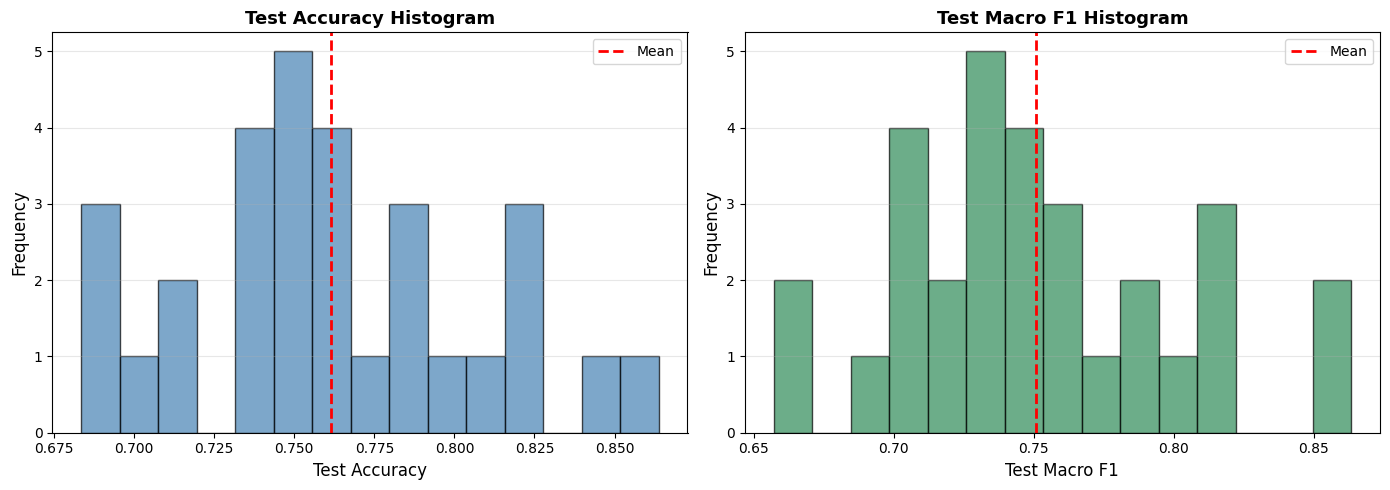

In [12]:
# Plot distributions for temporal front-view runs
plot_multi_run_distributions(multi_run_results_temporal_front, aggregated_stats_temporal_front)


TEMPORAL FRONT VIEW: BEST vs WORST RUN COMPARISON
Best Run:  #1 (seed=43) - Acc: 0.8638, F1: 0.8634
Worst Run: #9 (seed=51) - Acc: 0.6834, F1: 0.6570


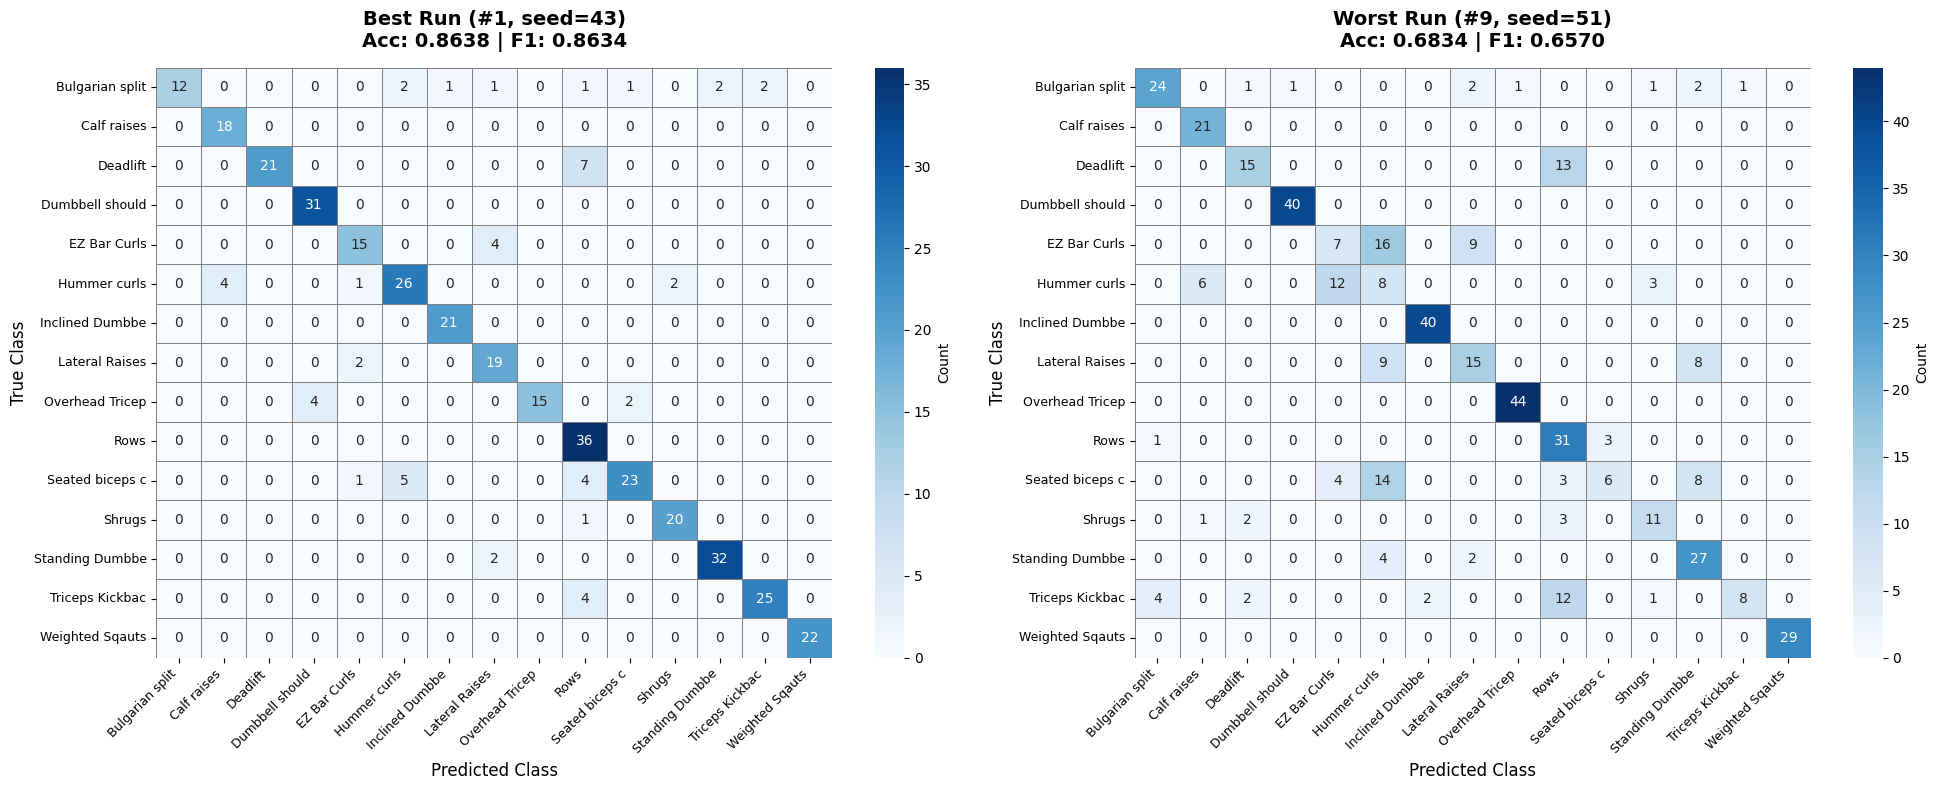


Per-Class F1 Comparison (Best vs Worst):
       Best Run  Worst Run  Difference
Class                                 
0        0.7059     0.7742     -0.0683
1        0.9000     0.8571      0.0429
2        0.8571     0.6250      0.2321
3        0.9394     0.9877     -0.0483
4        0.7895     0.2545      0.5349
5        0.7879     0.2000      0.5879
6        0.9767     0.9756      0.0011
7        0.8085     0.5000      0.3085
8        0.8333     0.9888     -0.1554
9        0.8090     0.6392      0.1698
10       0.7797     0.2727      0.5069
11       0.9302     0.6667      0.2636
12       0.9412     0.6923      0.2489
13       0.8929     0.4211      0.4718
14       1.0000     1.0000     -0.0000


In [13]:
# Best vs worst run comparison for temporal front-view
label_names_temporal = sorted(multi_run_results_temporal_front[0]['label_to_int'].keys())
ordered_labels_temporal = sort_labels_by_numeric_prefix(label_names_temporal)

print("\n" + "=" * 80)
print("TEMPORAL FRONT VIEW: BEST vs WORST RUN COMPARISON")
print("=" * 80)
comparison_df_temporal_front = plot_best_worst_comparison(multi_run_results_temporal_front, ordered_labels_temporal)

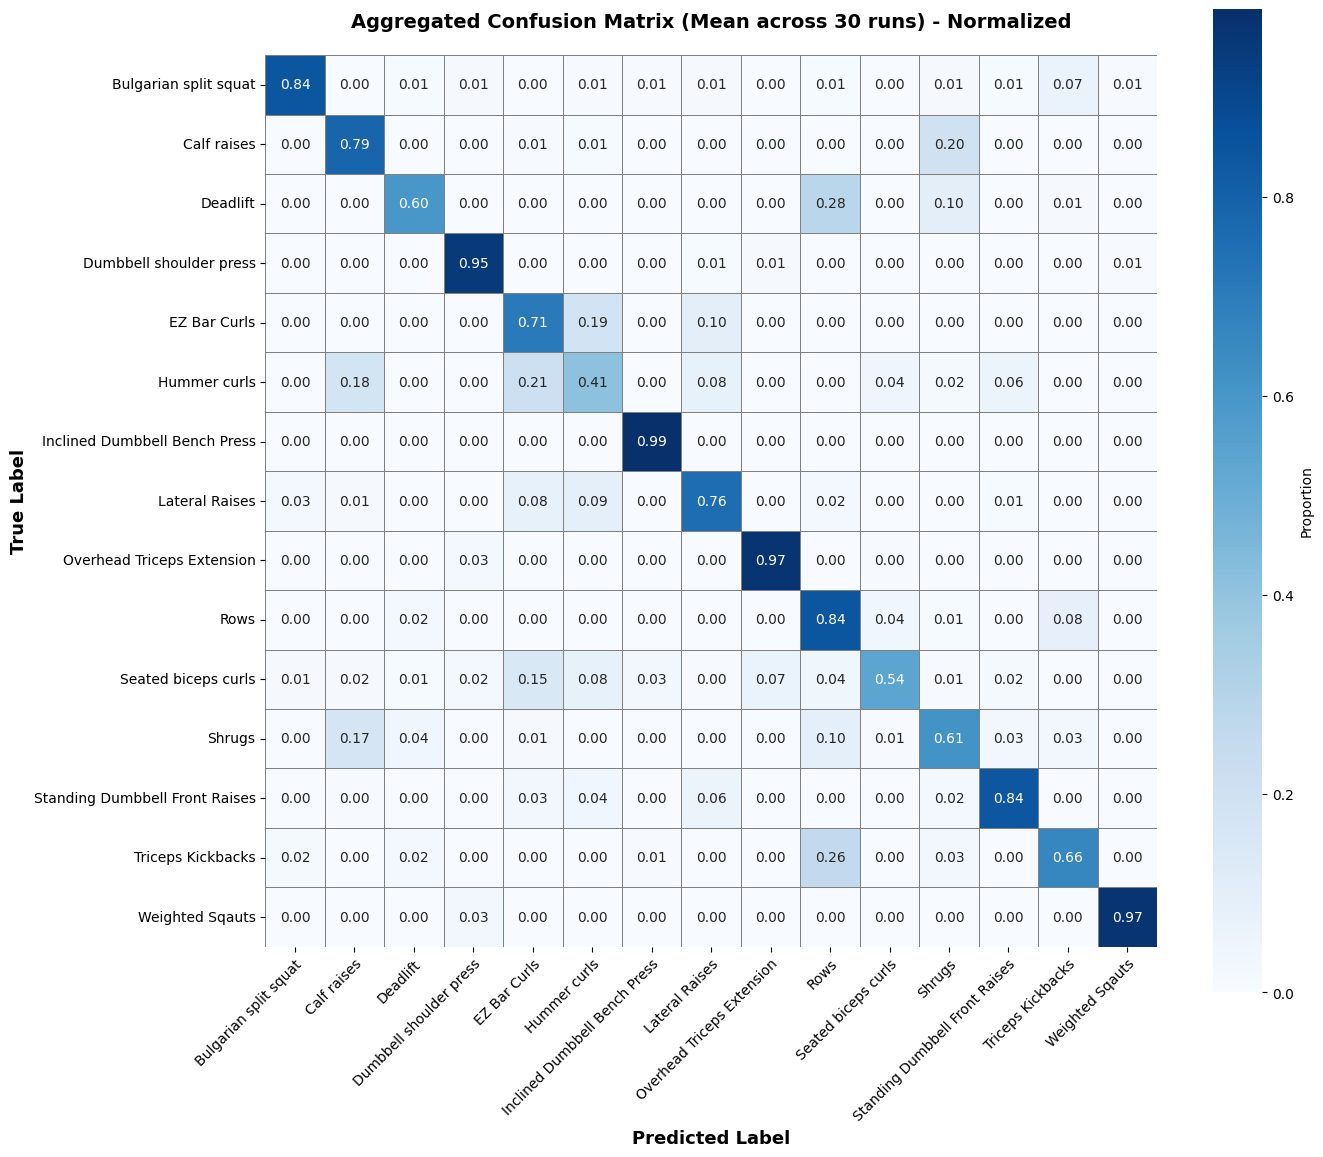

array([[2.22333333e+01, 0.00000000e+00, 2.66666667e-01, 3.33333333e-01,
        6.66666667e-02, 1.33333333e-01, 1.66666667e-01, 3.33333333e-01,
        6.66666667e-02, 2.33333333e-01, 1.00000000e-01, 3.33333333e-01,
        2.33333333e-01, 1.73333333e+00, 1.33333333e-01],
       [0.00000000e+00, 1.65333333e+01, 0.00000000e+00, 0.00000000e+00,
        1.33333333e-01, 2.33333333e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.13333333e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.33333333e-02, 0.00000000e+00, 1.54333333e+01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.66666667e-02, 0.00000000e+00,
        0.00000000e+00, 7.33333333e+00, 6.66666667e-02, 2.63333333e+00,
        0.00000000e+00, 3.66666667e-01, 0.00000000e+00],
       [3.33333333e-02, 0.00000000e+00, 3.33333333e-02, 3.67000000e+01,
        1.33333333e-01, 0.00000000e+00, 0.00000000e+00, 4.33333333e-01,
        5.66666667e-01, 0.00000000e+0

In [14]:
# Aggregated confusion matrix for temporal front-view
plot_aggregated_confusion_matrix(
    multi_run_results_temporal_front,
    label_names=ordered_labels_temporal,
    desired_class_order=ordered_labels_temporal,
    normalize=True
)

## Temporal Side View: Multi-Run Analysis

Detailed analysis of 30 runs for temporal side-view model.

In [15]:
# Display summary table for temporal side-view runs
print("=" * 80)
print("TEMPORAL SIDE VIEW: SUMMARY OF 30 RUNS")
print("=" * 80)
summary_df_temporal_side = display_multi_run_summary(multi_run_results_temporal_side, aggregated_stats_temporal_side)

TEMPORAL SIDE VIEW: SUMMARY OF 30 RUNS
AGGREGATED STATISTICS (30 runs)

Test Accuracy:  0.8427 ± 0.0551
  Min: 0.6476
  Max: 0.9065

Test Macro F1:  0.8360 ± 0.0554
  Min: 0.6417
  Max: 0.8991


Per-Class F1 Statistics (Mean ± Std):
         mean     std     min     max
Class                                
0      0.8479  0.1348  0.4615  1.0000
1      0.7881  0.1087  0.5714  0.9706
2      0.9301  0.0545  0.7843  1.0000
3      0.7742  0.1984  0.0556  1.0000
4      0.8243  0.1316  0.3846  1.0000
5      0.7514  0.1430  0.3462  0.9687
6      0.9016  0.0989  0.5974  1.0000
7      0.7385  0.1490  0.4906  0.9863
8      0.7924  0.1001  0.5909  1.0000
9      0.9133  0.0540  0.7667  1.0000
10     0.9370  0.0754  0.8136  1.0000
11     0.6789  0.1873  0.2963  0.9744
12     0.8442  0.1529  0.3750  1.0000
13     0.9038  0.0769  0.6786  1.0000
14     0.9138  0.1429  0.3077  1.0000


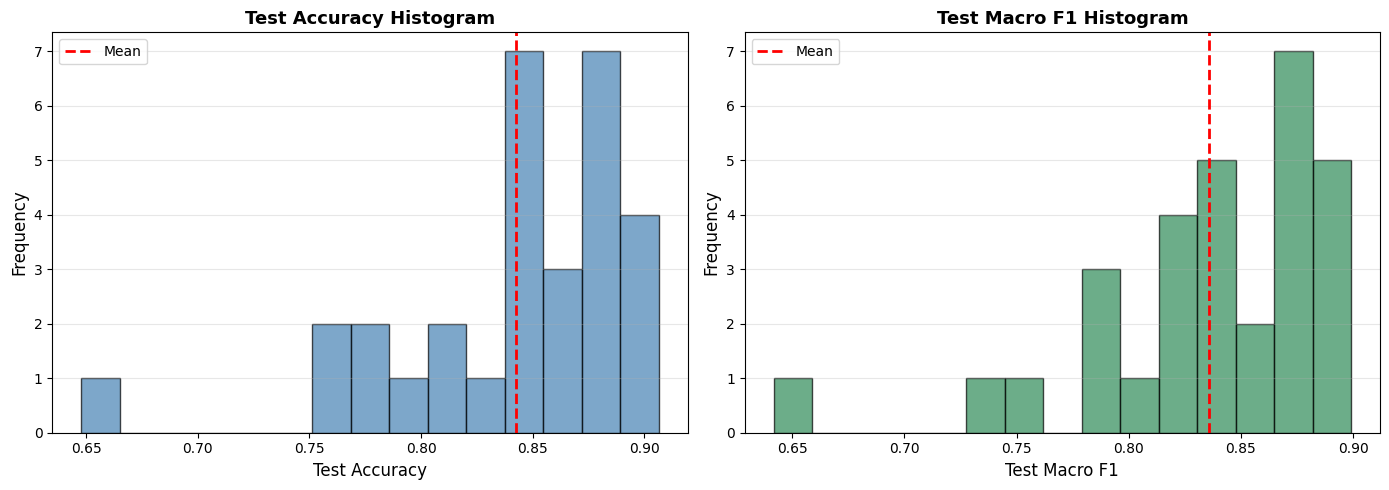

In [16]:
# Plot distributions for temporal side-view runs
plot_multi_run_distributions(multi_run_results_temporal_side, aggregated_stats_temporal_side)


TEMPORAL SIDE VIEW: BEST vs WORST RUN COMPARISON
Best Run:  #26 (seed=68) - Acc: 0.9373, F1: 0.9381
Worst Run: #6 (seed=48) - Acc: 0.7466, F1: 0.7535


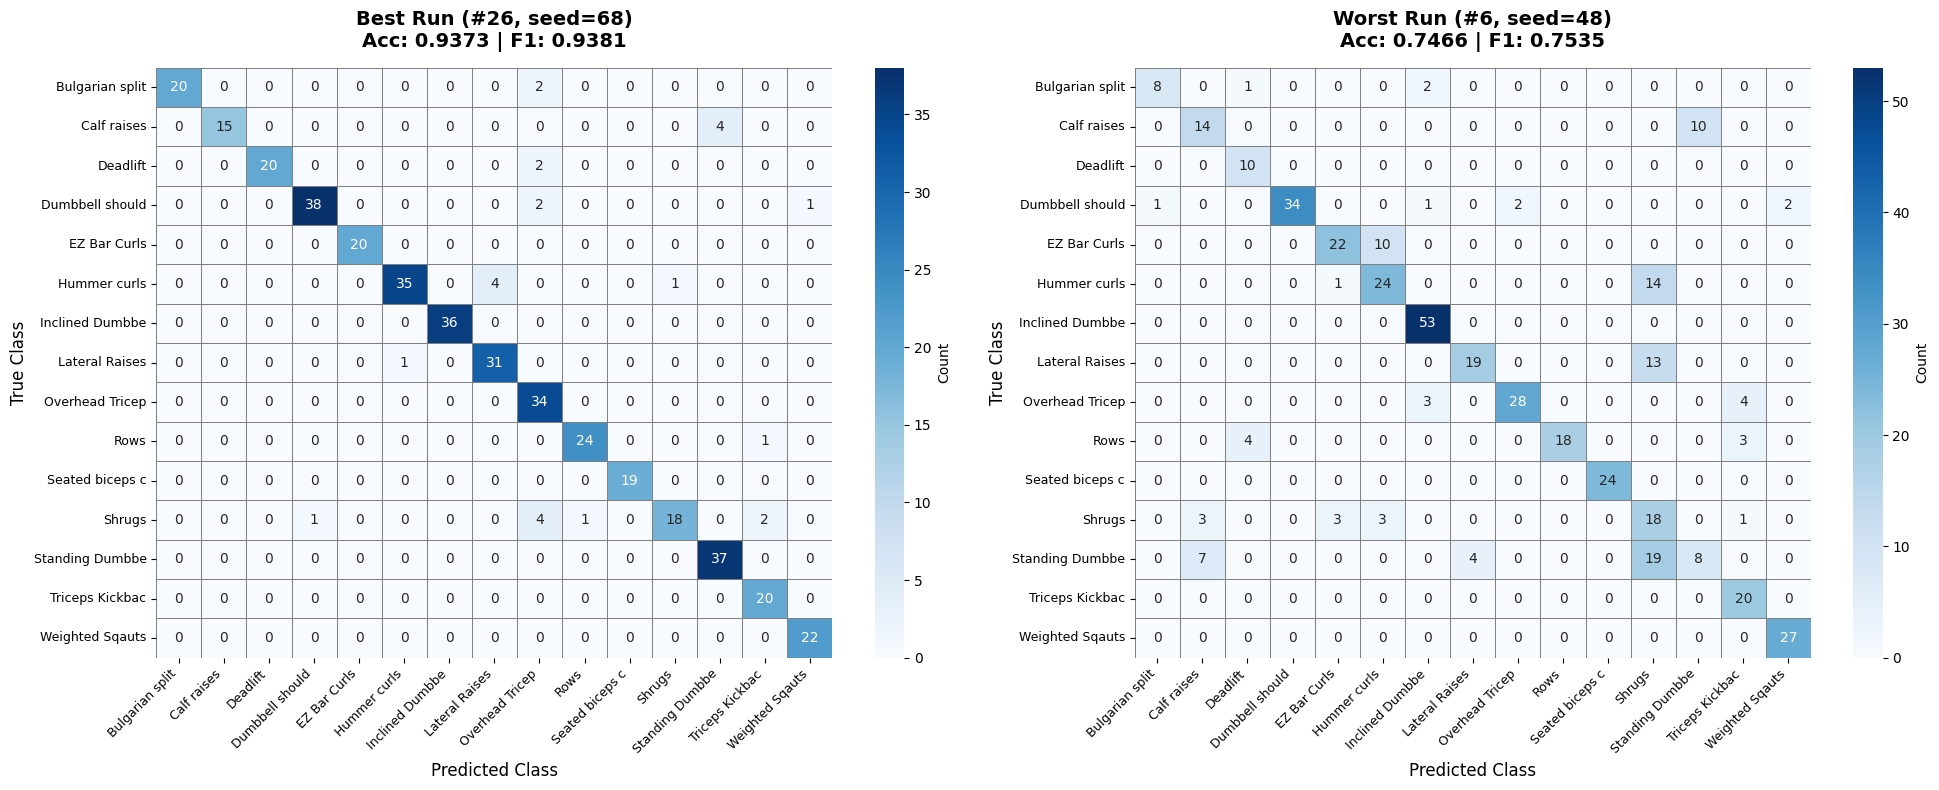


Per-Class F1 Comparison (Best vs Worst):
       Best Run  Worst Run  Difference
Class                                 
0        0.9524     0.8000      0.1524
1        0.8824     0.5833      0.2990
2        0.9524     0.8000      0.1524
3        0.9500     0.9189      0.0311
4        1.0000     0.7586      0.2414
5        0.9211     0.6316      0.2895
6        1.0000     0.9464      0.0536
7        0.9254     0.6909      0.2345
8        0.8718     0.8615      0.0103
9        0.9600     0.8372      0.1228
10       1.0000     1.0000     -0.0000
11       0.8000     0.3913      0.4087
12       0.9487     0.2857      0.6630
13       0.9302     0.8333      0.0969
14       0.9778     0.9643      0.0135


In [29]:
# Best vs worst run comparison for temporal side-view
print("\n" + "=" * 80)
print("TEMPORAL SIDE VIEW: BEST vs WORST RUN COMPARISON")
print("=" * 80)
comparison_df_temporal_side = plot_best_worst_comparison(multi_run_results_temporal_side, ordered_labels_temporal)

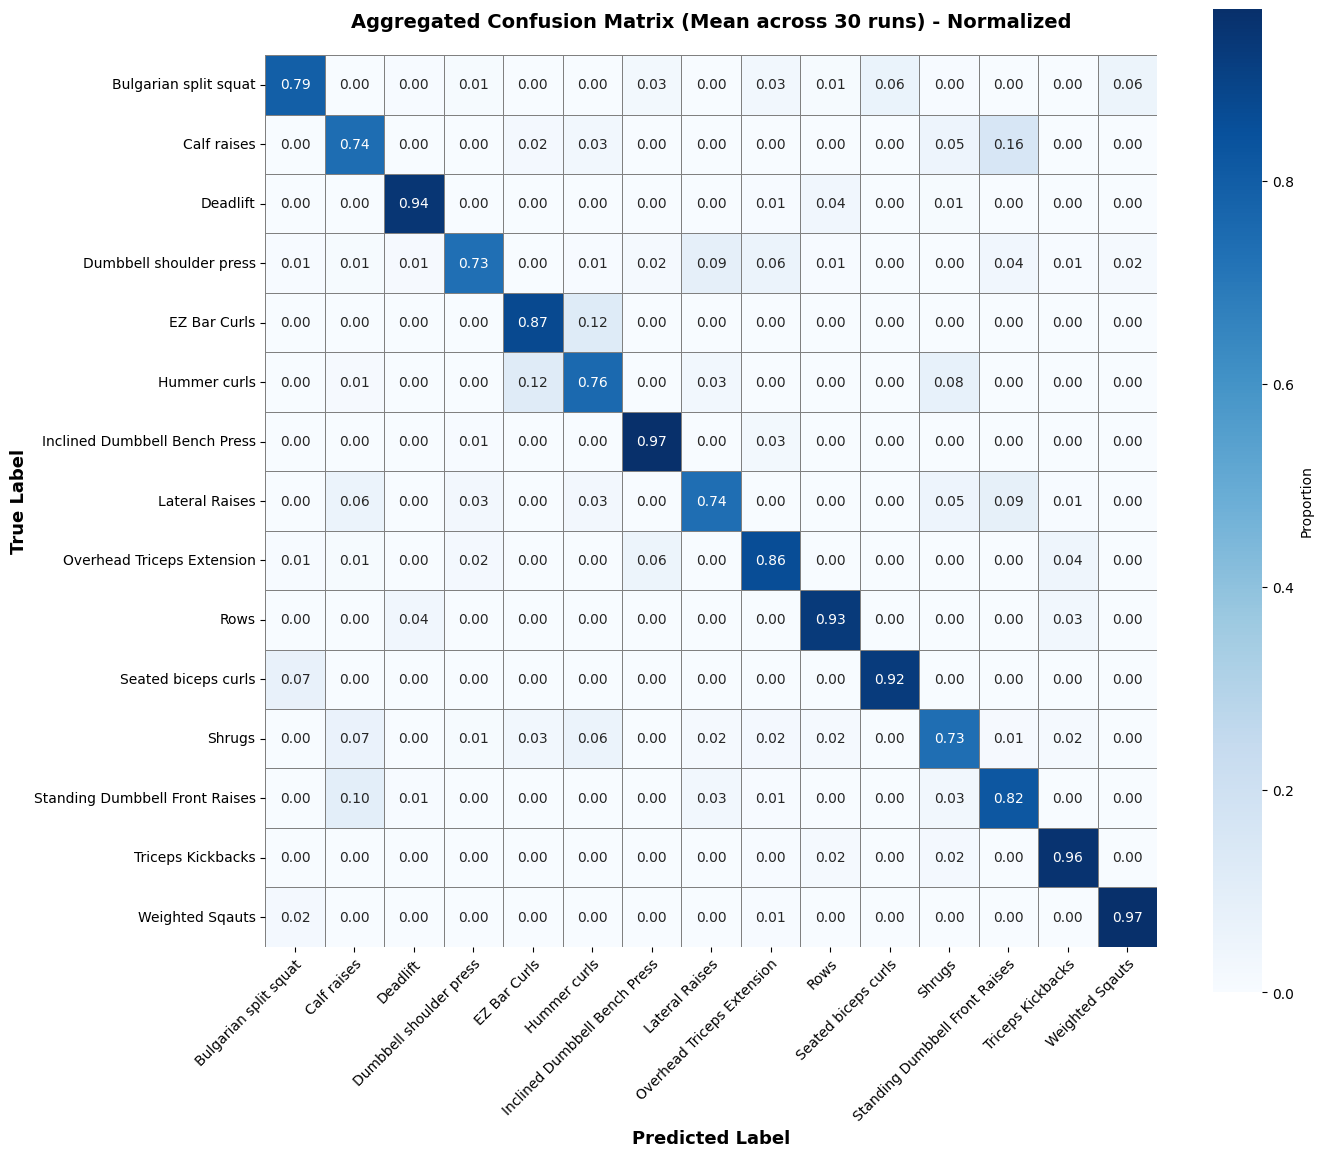

array([[2.08000000e+01, 6.66666667e-02, 1.00000000e-01, 2.33333333e-01,
        3.33333333e-02, 0.00000000e+00, 6.66666667e-01, 0.00000000e+00,
        8.33333333e-01, 2.66666667e-01, 1.60000000e+00, 1.00000000e-01,
        0.00000000e+00, 6.66666667e-02, 1.46666667e+00],
       [0.00000000e+00, 1.93666667e+01, 0.00000000e+00, 0.00000000e+00,
        5.33333333e-01, 8.33333333e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.33333333e+00,
        4.16666667e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.36000000e+01, 0.00000000e+00,
        0.00000000e+00, 3.33333333e-02, 0.00000000e+00, 0.00000000e+00,
        1.33333333e-01, 9.33333333e-01, 6.66666667e-02, 2.33333333e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.33333333e-01, 4.33333333e-01, 5.33333333e-01, 3.21666667e+01,
        0.00000000e+00, 2.33333333e-01, 7.00000000e-01, 3.93333333e+00,
        2.56666667e+00, 2.66666667e-0

In [30]:
# Aggregated confusion matrix for temporal side-view
plot_aggregated_confusion_matrix(
    multi_run_results_temporal_side,
    label_names=ordered_labels_temporal,
    desired_class_order=ordered_labels_temporal,
    normalize=True
)

---

## Cross-Model Visualizations: Temporal Front vs Side

Side-by-side comparisons of best runs from each temporal view.

In [31]:
# Get best runs from each temporal view for detailed comparison
best_run_temporal_front = max(multi_run_results_temporal_front, key=lambda x: x['test_metrics']['macro_f1'])
best_run_temporal_side = max(multi_run_results_temporal_side, key=lambda x: x['test_metrics']['macro_f1'])

print("Best Run Performance (Temporal):")
print(f"  Front View - Accuracy: {best_run_temporal_front['test_metrics']['accuracy']:.4f}, Macro F1: {best_run_temporal_front['test_metrics']['macro_f1']:.4f}")
print(f"  Side View  - Accuracy: {best_run_temporal_side['test_metrics']['accuracy']:.4f}, Macro F1: {best_run_temporal_side['test_metrics']['macro_f1']:.4f}")

Best Run Performance (Temporal):
  Front View - Accuracy: 0.8086, Macro F1: 0.8030
  Side View  - Accuracy: 0.9373, Macro F1: 0.9381


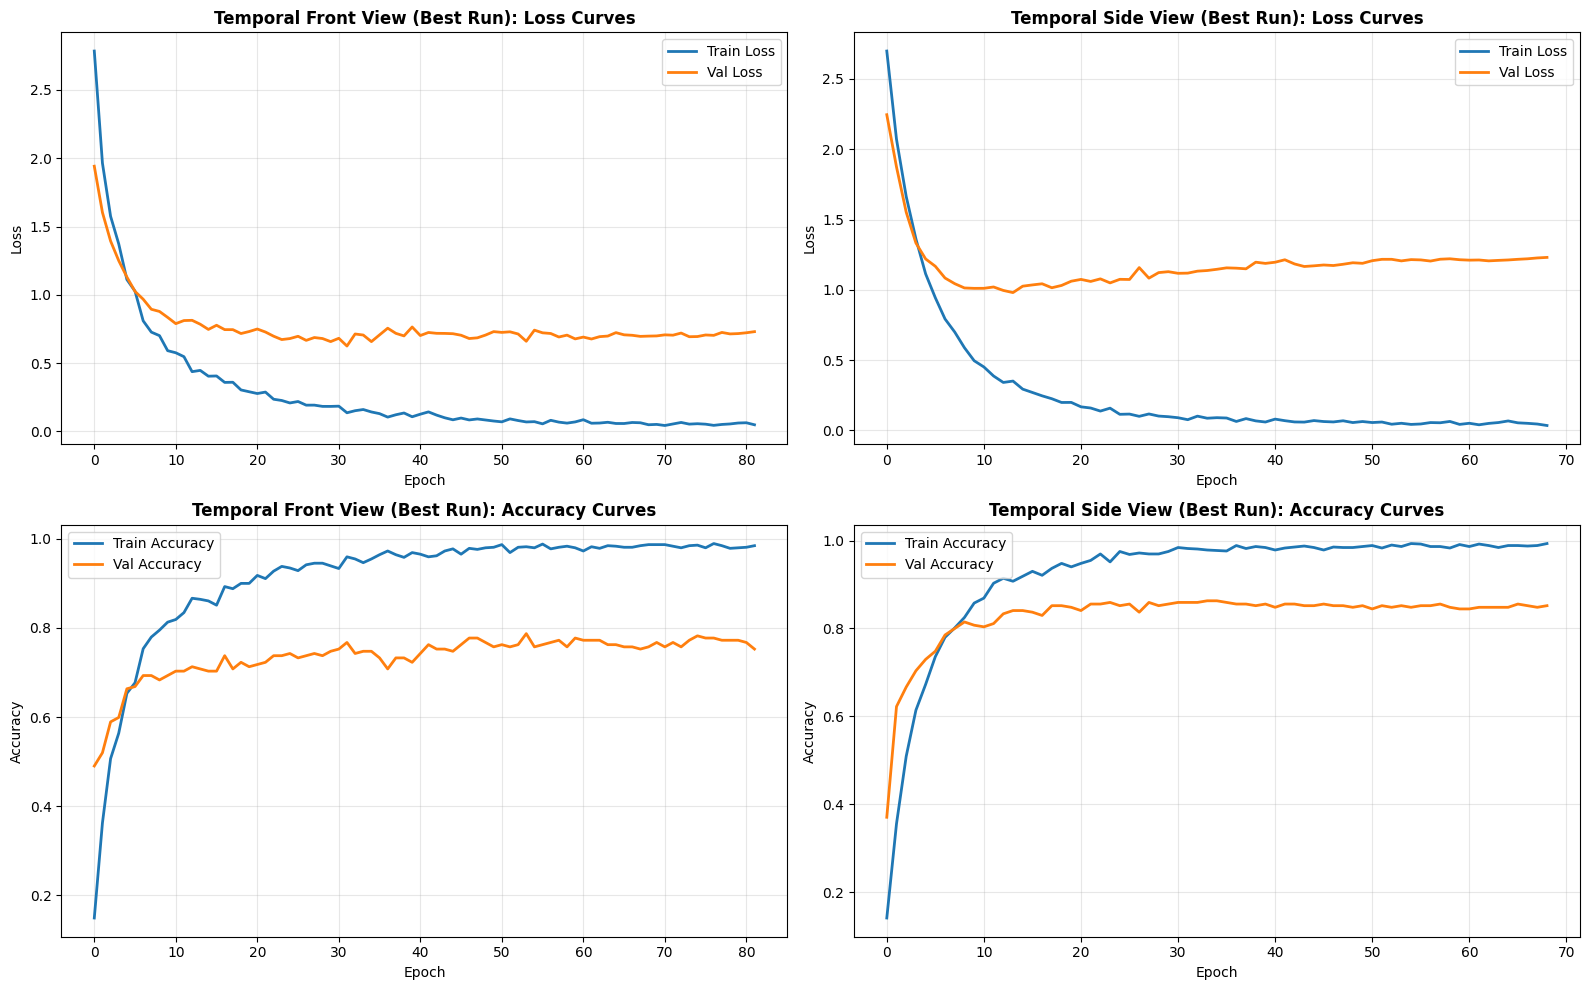

Temporal Front View (Best Run) training: 82 epochs
Temporal Side View (Best Run) training: 69 epochs


In [32]:
# Plot training curves for best temporal runs side-by-side
plot_dual_training_history(
    best_run_temporal_front['history'],
    best_run_temporal_side['history'],
    model_names=['Temporal Front View (Best Run)', 'Temporal Side View (Best Run)']
)

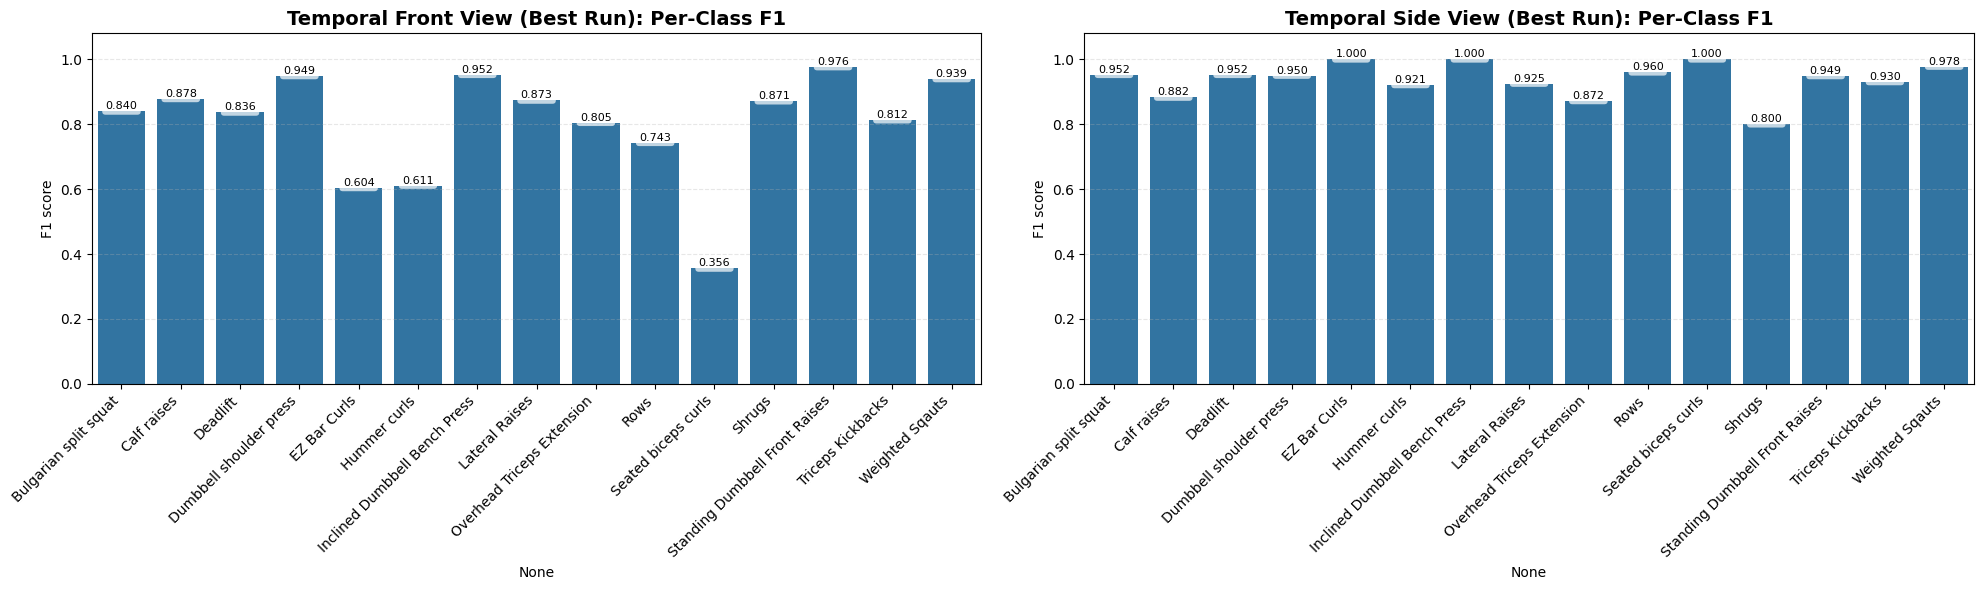

In [33]:
# Side-by-side per-class F1 comparison (best temporal runs)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

idx_to_label_temporal = {int(k): v for k, v in best_run_temporal_front['int_to_label'].items()}

per_class_f1_temporal_front = plot_per_class_f1_scores(
    best_run_temporal_front['test_metrics']['per_class_f1'],
    idx_to_label_temporal,
    desired_class_order=ordered_labels_temporal,
    ax=axes[0]
)
axes[0].set_title('Temporal Front View (Best Run): Per-Class F1', fontsize=14, fontweight='bold')

per_class_f1_temporal_side = plot_per_class_f1_scores(
    best_run_temporal_side['test_metrics']['per_class_f1'],
    idx_to_label_temporal,
    desired_class_order=ordered_labels_temporal,
    ax=axes[1]
)
axes[1].set_title('Temporal Side View (Best Run): Per-Class F1', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

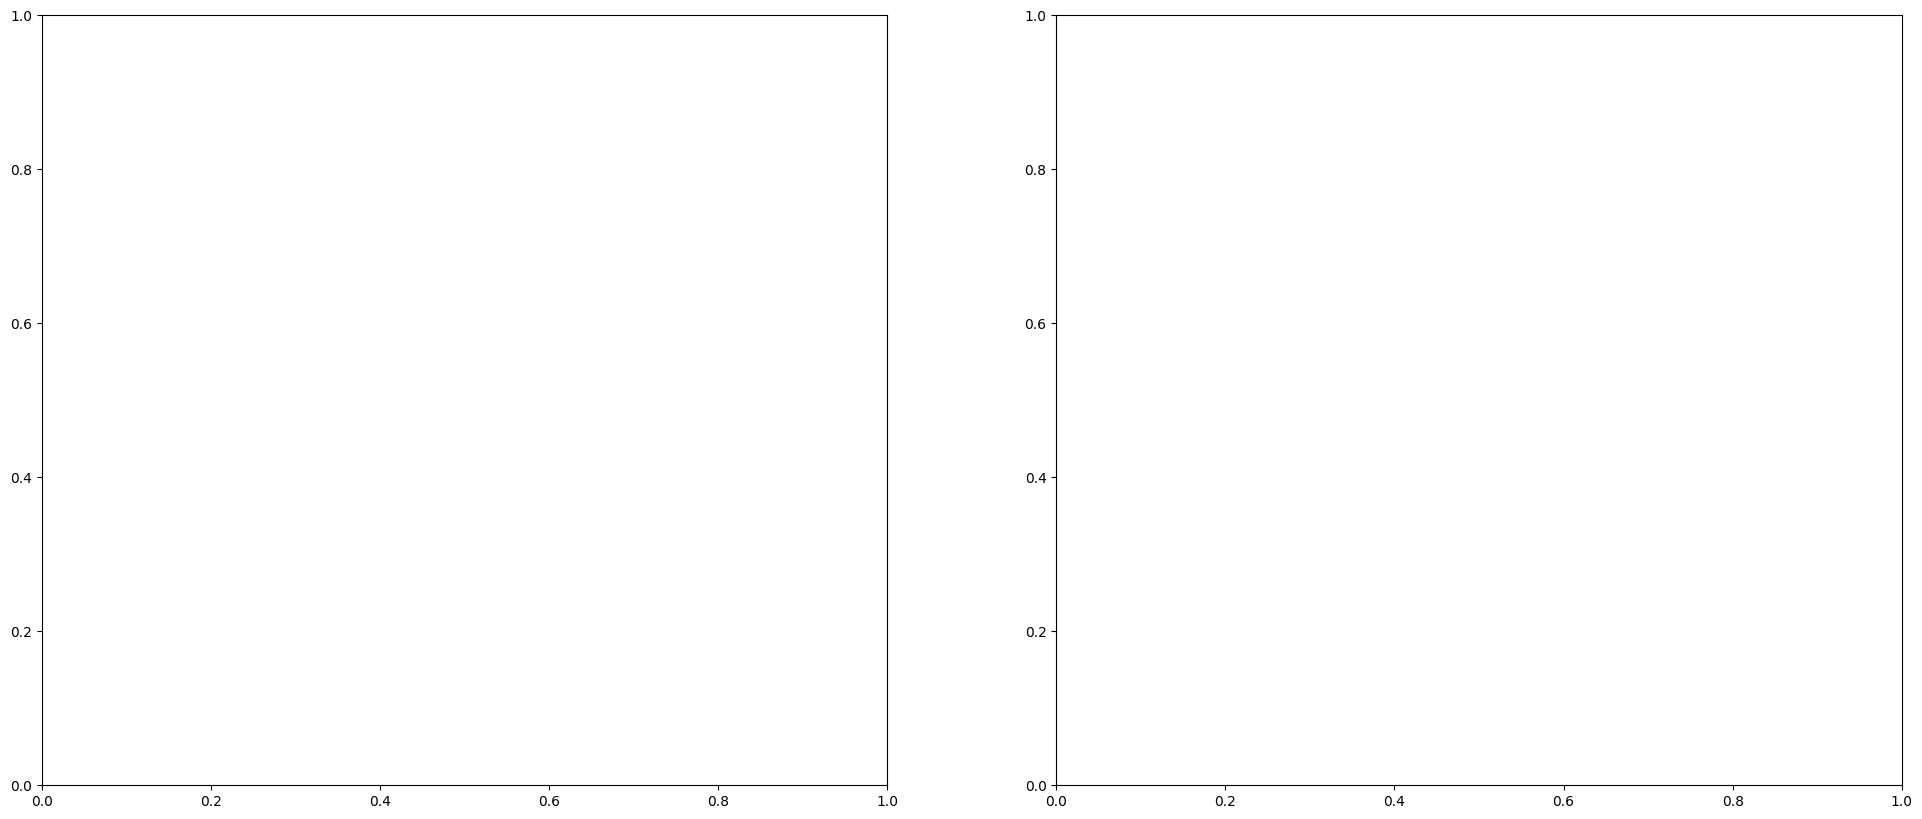

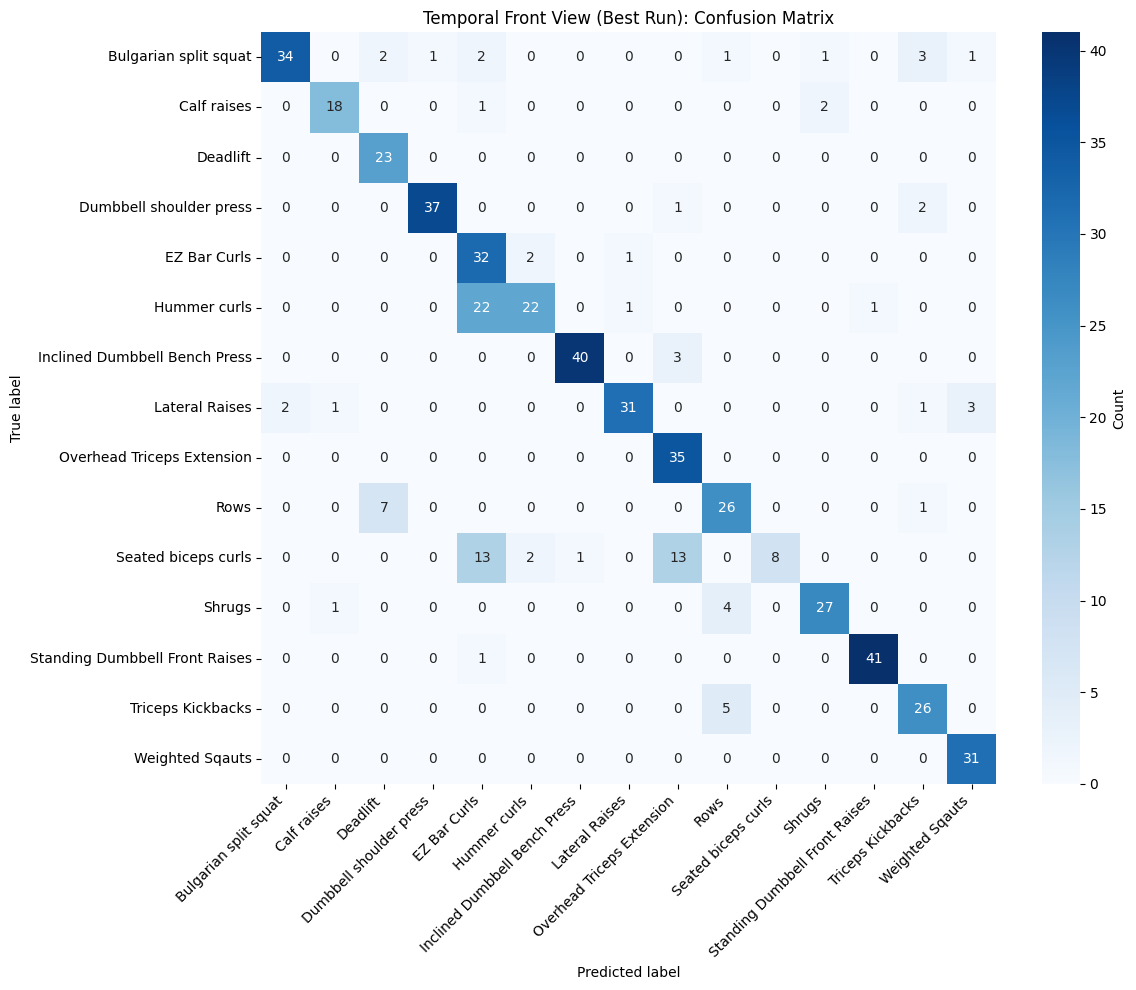

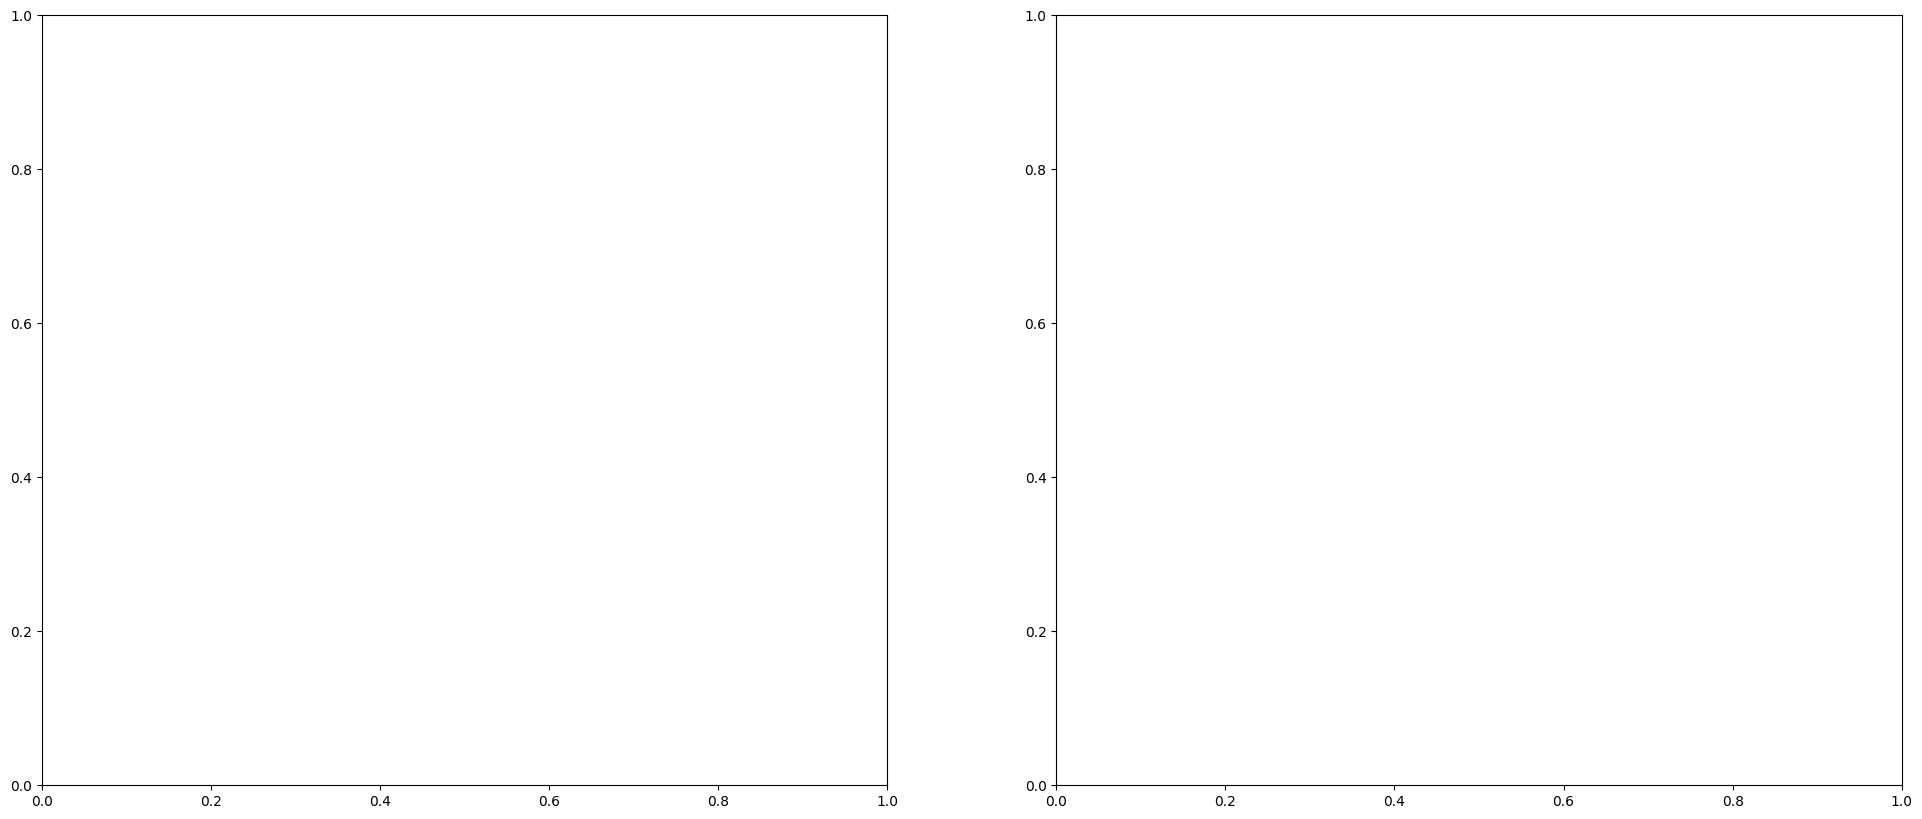

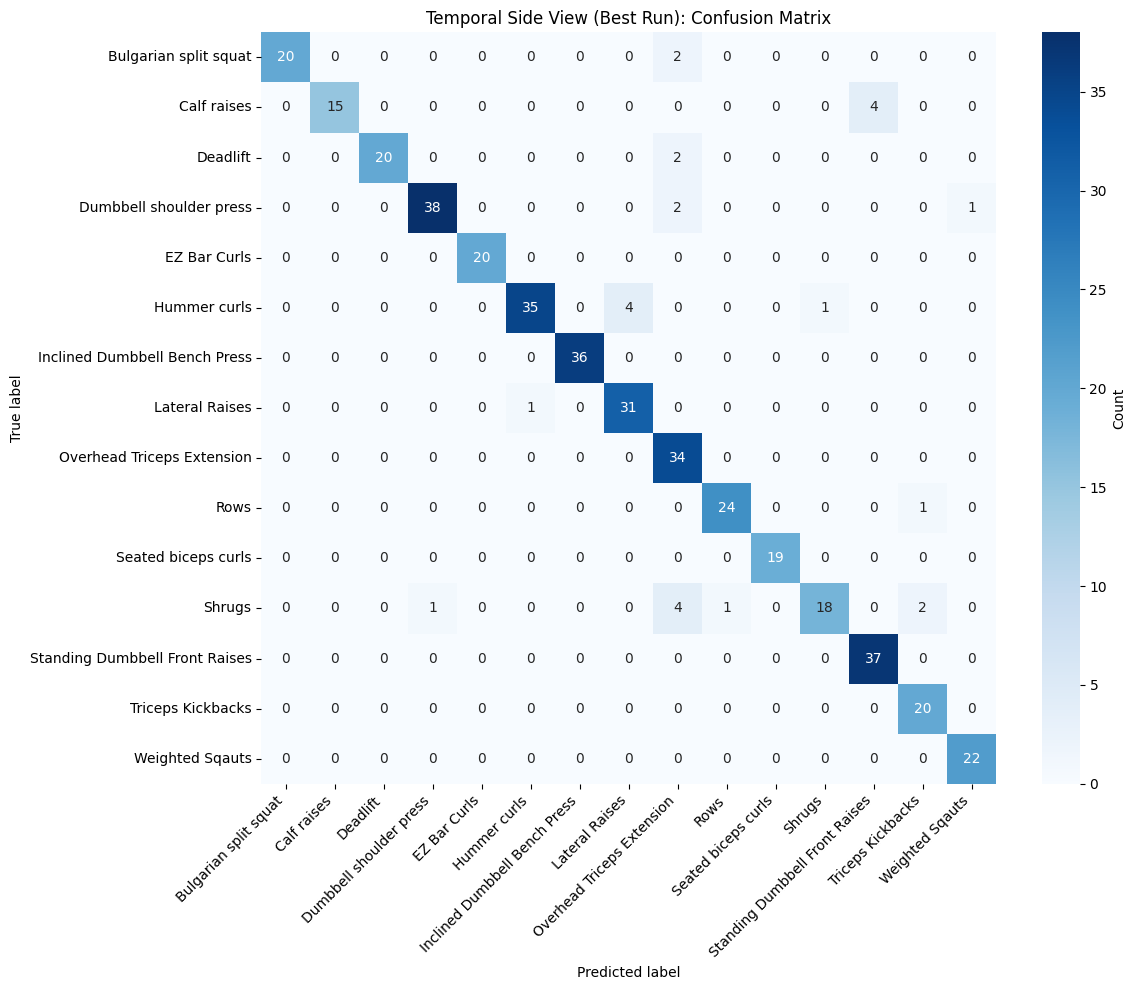

<Figure size 640x480 with 0 Axes>

In [34]:
# Side-by-side confusion matrices (best temporal runs)
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

conf_matrix_temporal_front = np.array(best_run_temporal_front['test_metrics']['confusion_matrix'])
plt.sca(axes[0])
plot_confusion_matrix_from_metrics(
    conf_matrix_temporal_front,
    current_class_order=label_names_temporal,
    desired_class_order=ordered_labels_temporal,
    normalize=False,
    title='Temporal Front View (Best Run): Confusion Matrix'
)

conf_matrix_temporal_side = np.array(best_run_temporal_side['test_metrics']['confusion_matrix'])
plt.sca(axes[1])
plot_confusion_matrix_from_metrics(
    conf_matrix_temporal_side,
    current_class_order=label_names_temporal,
    desired_class_order=ordered_labels_temporal,
    normalize=False,
    title='Temporal Side View (Best Run): Confusion Matrix'
)

plt.tight_layout()
plt.show()

---

## Final Comparison: Static vs Temporal Features

This section provides a comprehensive comparison between hand-crafted statistical features (static) and raw temporal sequences (temporal) to understand which feature engineering approach is more effective for the MLP baseline.

In [35]:
# Compare static vs temporal for front view
print("=" * 80)
print("FRONT VIEW: STATIC vs TEMPORAL COMPARISON")
print("=" * 80)
comparison_df_front_static_vs_temporal = compare_multi_run_stats(
    aggregated_stats_front,
    aggregated_stats_temporal_front,
    model_names=['Static Front', 'Temporal Front']
)

FRONT VIEW: STATIC vs TEMPORAL COMPARISON
MULTI-RUN STATISTICAL COMPARISON: Static Front vs Temporal Front

       Metric    Static Front  Temporal Front
Test Accuracy 0.6937 ± 0.0481 0.7543 ± 0.0423
Test Macro F1 0.6659 ± 0.0613 0.7214 ± 0.0569




In [37]:
# Compare static vs temporal for side view
print("\n" + "=" * 80)
print("SIDE VIEW: STATIC vs TEMPORAL COMPARISON")
print("=" * 80)
comparison_df_side_static_vs_temporal = compare_multi_run_stats(
    aggregated_stats_side,
    aggregated_stats_temporal_side,
    model_names=['Static Side', 'Temporal Side']
)


SIDE VIEW: STATIC vs TEMPORAL COMPARISON


NameError: name 'aggregated_stats_side' is not defined

In [ ]:
# Overall comparison: All 4 models
print("\n" + "=" * 80)
print("COMPREHENSIVE COMPARISON: ALL MODELS")
print("=" * 80)

all_models_stats = {
    'Static Front': aggregated_stats_front,
    'Static Side': aggregated_stats_side,
    'Temporal Front': aggregated_stats_temporal_front,
    'Temporal Side': aggregated_stats_temporal_side
}

# Create comparison DataFrame
comparison_data = []
for model_name, stats in all_models_stats.items():
    comparison_data.append({
        'Model': model_name,
        'Test Accuracy (Mean)': f"{stats['test_accuracy']['mean']:.4f}",
        'Test Accuracy (Std)': f"{stats['test_accuracy']['std']:.4f}",
        'Test Macro F1 (Mean)': f"{stats['test_macro_f1']['mean']:.4f}",
        'Test Macro F1 (Std)': f"{stats['test_macro_f1']['std']:.4f}",
        'Accuracy Range': f"[{stats['test_accuracy']['min']:.4f}, {stats['test_accuracy']['max']:.4f}]",
        'F1 Range': f"[{stats['test_macro_f1']['min']:.4f}, {stats['test_macro_f1']['max']:.4f}]"
    })

comparison_df_all = pd.DataFrame(comparison_data)
print("\n")
print(comparison_df_all.to_string(index=False))
print("\n")

# Find best model overall
best_model_name = max(all_models_stats.keys(), key=lambda x: all_models_stats[x]['test_macro_f1']['mean'])
best_f1 = all_models_stats[best_model_name]['test_macro_f1']['mean']
print(f"🏆 Best Model (by mean macro F1): {best_model_name} with F1 = {best_f1:.4f}")
print("=" * 80)


COMPREHENSIVE COMPARISON: ALL MODELS


         Model Test Accuracy (Mean) Test Accuracy (Std) Test Macro F1 (Mean) Test Macro F1 (Std)   Accuracy Range         F1 Range
  Static Front               0.6505              0.0545               0.6478              0.0482 [0.5287, 0.8032] [0.5485, 0.7928]
   Static Side               0.8270              0.0315               0.8098              0.0319 [0.7754, 0.8952] [0.7488, 0.8825]
Temporal Front               0.7032              0.0601               0.7006              0.0546 [0.5586, 0.7970] [0.5813, 0.7945]
 Temporal Side               0.8926              0.0264               0.8774              0.0288 [0.8378, 0.9490] [0.8116, 0.9324]


🏆 Best Model (by mean macro F1): Temporal Side with F1 = 0.8774
